# What this note can do?

NOTE: we creaed original imput files by Extract_nongap-sites_on_HXB2_Rhesus_DNA.ipynb, which can be found at /Users/kais/Documents/CODE/HMMER_HIV/note/

- Table of index and mutation strength. 
- From this CSV file, determin Abs resitance mutation. 

In [80]:
#Pkg.add("Pkg"); import Pkg; 
using Pkg
using Distributed
using DelimitedFiles
using Profile    
using Random
using Statistics
using LinearAlgebra
using Plots
using Printf
using Measures
using CSV
using LaTeXStrings;
using DataFrames
rng = Random.MersenneTwister(1234);

In [77]:
include("../src/basic_MPL.jl");
include("../src/basic.jl")
include("../src/my_HIV_data_cleanign.jl")
include("../src/basic_analysis.jl")
include("../src/non_synonymous_N-glycan.jl") 
include("../src/process_HIV_mutation_for_CSV.jl") 
NUC = ["-", "A", "C", "G", "T"];

# Processes Start

## Retrieve variable and antibody binding sites 

In [16]:
# Keep trucking only the following sites and nucleotides;
# Should include also HXB2 inde for protein and genes. 
hxb2csv = DataFrame(CSV.File("../data/csv/hxb2.csv"));
csv_raw_CH103binding = DataFrame(CSV.File("../data/csv/CH103_binding.csv"))
csv_raw_CH235binding = DataFrame(CSV.File("../data/csv/CH235_binding.csv"))
csv_raw_CD4contact = DataFrame(CSV.File("../data/csv/CD4_contct_residue.csv"))
csv_raw_V1_HV = DataFrame(CSV.File("../data/csv/V1_Hypervariable_residue.csv"))
csv_raw_V2_HV = DataFrame(CSV.File("../data/csv/V2_Hypervariable_residue.csv"))
csv_raw_V3_HV = DataFrame(CSV.File("../data/csv/V3_Hypervariable_residue.csv"))
csv_raw_V4_HV = DataFrame(CSV.File("../data/csv/V4_Hypervariable_residue.csv"))
csv_raw_V5_HV = DataFrame(CSV.File("../data/csv/V5_Hypervariable_residue.csv"))
csv_raw_LoopD = DataFrame(CSV.File("../data/csv/Loop-D_residue.csv"));

csv_raw_resist_mut_CH103 = DataFrame(CSV.File("../data/csv/resistant_mut_to_CH103.csv")) 
csv_raw_resist_mut_CH235 = DataFrame(CSV.File("../data/csv/resistant_mut_to_CH235.csv")) 
csv_raw_resist_strain_specific_Abs_CH505 = DataFrame(CSV.File("../data/csv/resistant_mut_to_strain_specific-bnAbs_CH505.csv")) 
csv_raw_common_mut_SHIV_CH505 = DataFrame(CSV.File("../data/csv/common_mutation_rhesus_SHIV505.csv")) ;

## Formatting the files

In [13]:
csv_selection = DataFrame(CSV.File("../data/mpl/703010505-3-poly.csv"));

gene_set = [[] for _ in 1:3]; vec_AA_idx = [[] for _ in 1:3]; HXB2_set = [[] for _ in 1:3]; 
vec_nuc_idx = []; frame_set = []; 
for x in csv_selection.HXB2_index
    num_nuc = get_num_nuc(x)
    frame, gene = index2frame(num_nuc)
    num_nuc, num_AA, gene = map_numNUC_to_numAA(x, frame)
    #@assert(gene==gene_check)
    
    push!(frame_set, frame)
    push!(vec_nuc_idx, num_nuc)
    for fr in 1:3 
        push!(gene_set[fr], gene[fr])
        push!(vec_AA_idx[fr], num_AA[fr])
        push!(HXB2_set[fr], HXB2(num_nuc, num_AA[fr], gene[fr]))
    end
end;

@printf("Fr.1: gene: %s\n", join(unique(gene_set[1]), ", "));
@printf("Fr.2: gene: %s\n", join(unique(gene_set[2]), ", "));
@printf("Fr.3: gene: %s\n", join(unique(gene_set[3]), ", "));
@printf("max: %d, %d\n", maximum(skipmissing(vec_nuc_idx)), maximum(skipmissing(vec_nuc_idx))) 
@printf("min: %d, %d\n", minimum(skipmissing(vec_nuc_idx)), minimum(skipmissing(vec_nuc_idx)));

# Use frame 3 where Env gene belongs. 
vec_CH103_binding = get_true_false_variable_region(vec_AA_idx[3], csv_raw_CH103binding)
vec_CH235_binding = get_true_false_variable_region(vec_AA_idx[3], csv_raw_CH235binding)
vec_CD4contact_binding = get_true_false_variable_region(vec_AA_idx[3], csv_raw_CD4contact)
vec_V1 = get_true_false_variable_region(vec_AA_idx[3], csv_raw_V1_HV)
vec_V2 = get_true_false_variable_region(vec_AA_idx[3], csv_raw_V2_HV)
vec_V3 = get_true_false_variable_region(vec_AA_idx[3], csv_raw_V3_HV)
vec_V4 = get_true_false_variable_region(vec_AA_idx[3], csv_raw_V4_HV)
vec_V5 = get_true_false_variable_region(vec_AA_idx[3], csv_raw_V5_HV)
vec_LoopD = get_true_false_variable_region(vec_AA_idx[3], csv_raw_LoopD);

# These are all waat I need. 
csv_index_and_TF= DataFrame(CSV.File("../data/mpl/703010505-3-index.csv"));
seq_num_raw = readdlm("../data/mpl/703010505-3-poly-seq2state.dat", Int);

Fr.1: gene: , tat
Fr.2: gene: vpu, , rev
Fr.3: gene: env
max: 8795, 8795
min: 6225, 6225


## Processes to get mutations 

In [14]:
# ---- Get mutations ------#
(mutant_hxb2, mutant_nuc, mutant_date_found, mutant_gene, mutant_types_set_AA, 
mutant_types_set_nuc, mutant_types_set_nuc_simple, plus_glycan_set, minus_glycan_set, shifted_glycan_set
) = Make_combination_of_mutations_with_genetic_background_w_glycan(csv_index_and_TF, seq_num_raw, hxb2csv); 
mutant_types_set_AA_filtered = []
push!(mutant_types_set_AA_filtered, filtering_mutations_AA(mutant_types_set_AA[1]));
push!(mutant_types_set_AA_filtered, filtering_mutations_AA(mutant_types_set_AA[2]));
push!(mutant_types_set_AA_filtered, filtering_mutations_AA(mutant_types_set_AA[3]));


mutant_types_set_TF_AA = get_TF_AA(csv_index_and_TF, mutant_hxb2) ;
mutant_types_set_AA_filtered_v2 = []
push!(mutant_types_set_AA_filtered_v2, replacing_redundant_AA_by_TF(mutant_types_set_AA_filtered[1], mutant_types_set_TF_AA[1]))
push!(mutant_types_set_AA_filtered_v2, replacing_redundant_AA_by_TF(mutant_types_set_AA_filtered[2], mutant_types_set_TF_AA[2]))
push!(mutant_types_set_AA_filtered_v2, replacing_redundant_AA_by_TF(mutant_types_set_AA_filtered[3], mutant_types_set_TF_AA[3]));



i_raw=1 hxb2=6225 a_WT=A
cdn_bfr:ATG
cdn_afr:--G
Detected Codon: before>ATG & after>--G
Detected AA: before>M & after>-
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1 HXB2_idx:6225 nuc:- detected:673d
GENE:A6225- AA:M1- NUC:ATG6225-6227--G
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:vpu mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:ATG6225-6227--G mut_simple:A6225- mut_AA:M1-
cdn_bfr:ATG
cdn_afr:ATG
Detected Codon: before>ATG & after>ATG
Detected AA: before>M & after>M
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1 HXB2_idx:6225 nuc:A detected:0d
GENE:A6225A AA:M1M NUC:ATG6225-6227ATG
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:vpu mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:ATG6225-6227ATG mut_simple:A6225A mut_AA:M1M

i_raw=2 hxb2=6226 a_WT=T
cdn_bfr:ATG
cdn_afr:--G
Detected Codon: before>ATG & after>--G
Detected AA: before>M & after>-
Pos

Possible Transition (row: before, col: after): 
1 
1 
Possible Transition (After): 
0 
fr:2 gene:vpu poly_idx:17 HXB2_idx:6239b nuc:C detected:925d
GENE:T/G6239bC AA:D/E60D NUC:GAT/GAG6239-6239bGAC
cdn_bfr:ATA,AGA,AGG
cdn_afr:ACA
Detected Codon: before>ATA/AGA/AGG & after>ACA
Detected AA: before>I/R/R & after>T
Possible Transition (row: before, col: after): 
1 
1 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:17 HXB2_idx:6239b nuc:C detected:925d
GENE:T/G6239bC AA:I/R5T NUC:ATA/AGA6239a-6239cACA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:vpu mut:GAT/GAG6239-6239bGAC mut_simple:T/G6239bC mut_AA:D/E60D
fr:3 gen:env mut:ATA/AGA6239a-6239cACA mut_simple:T/G6239bC mut_AA:I/R5T
cdn_bfr:GAT
cdn_afr:GAG
Detected Codon: before>GAT & after>GAG
Detected AA: before>D & after>E
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:2 gene:vpu poly_idx:17 HXB2_idx:6239b nuc:G detected:343d
GENE:T6239bG AA:D60E NUC:GAT6239-6239bGAG
cdn_bfr:ATA
cdn

Fr.3: +N-glycan: 0, -N-glycan: 1 N-glycan-shift: 0

i_raw=27 hxb2=6242 a_WT=T
cdn_bfr:TTA
cdn_afr:CTA
Detected Codon: before>TTA & after>CTA
Detected AA: before>L & after>L
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:2 gene:vpu poly_idx:27 HXB2_idx:6242 nuc:C detected:519d
GENE:T6242C AA:L61L NUC:TTA6242-6244CTA
cdn_bfr:AAT
cdn_afr:AAC
Detected Codon: before>AAT & after>AAC
Detected AA: before>N & after>N
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:27 HXB2_idx:6242 nuc:C detected:519d
GENE:T6242C AA:N6N NUC:AAT6240-6242AAC
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:vpu mut:TTA6242-6244CTA mut_simple:T6242C mut_AA:L61L
fr:3 gen:env mut:AAT6240-6242AAC mut_simple:T6242C mut_AA:N6N
cdn_bfr:TTA
cdn_afr:TTA
Detected Codon: before>TTA & after>TTA
Detected AA: before>L & after>L
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:2 gene:vpu poly

fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:vpu mut:CAT6278-6280CAT mut_simple:T6280T mut_AA:H74H
fr:3 gen:env mut:ATG6279-6281ATG mut_simple:T6280T mut_AA:M19M

i_raw=67 hxb2=6282 a_WT=T
cdn_bfr:GTT
cdn_afr:GCT
Detected Codon: before>GTT & after>GCT
Detected AA: before>V & after>A
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:2 gene:vpu poly_idx:67 HXB2_idx:6282 nuc:C detected:1668d
GENE:T6282C AA:V74A NUC:GTT6281-6283GCT
cdn_bfr:TTA
cdn_afr:CTA
Detected Codon: before>TTA & after>CTA
Detected AA: before>L & after>L
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:67 HXB2_idx:6282 nuc:C detected:1668d
GENE:T6282C AA:L20L NUC:TTA6282-6284CTA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:vpu mut:GTT6281-6283GCT mut_simple:T6282C mut_AA:V74A
fr:3 gen:env mut:TTA6282-6284CTA mut_simple:T6282C mut_AA:L20L
cdn_bfr:GTT
cdn_afr:GTT
Detected Codon: before>GTT & after>GTT
Detected AA:

0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:84 HXB2_idx:6299 nuc:A detected:0d
GENE:A6299A AA:L25L NUC:CTA6297-6299CTA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:vpu mut:AAT6299-6301AAT mut_simple:A6299A mut_AA:N80N
fr:3 gen:env mut:CTA6297-6299CTA mut_simple:A6299A mut_AA:L25L
cdn_bfr:AAT
cdn_afr:GAT
Detected Codon: before>AAT & after>GAT
Detected AA: before>N & after>D
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:2 gene:vpu poly_idx:84 HXB2_idx:6299 nuc:G detected:43d
GENE:A6299G AA:N80D NUC:AAT6299-6301GAT
cdn_bfr:CTA
cdn_afr:CTG
Detected Codon: before>CTA & after>CTG
Detected AA: before>L & after>L
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:84 HXB2_idx:6299 nuc:G detected:43d
GENE:A6299G AA:L25L NUC:CTA6297-6299CTG
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:vpu mut:AAT6299-6301GAT mut_simple:A6299G mut_AA:N80D
fr:3 gen:env mut:CTA6297-6299CTG mu

fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GGG6312-6314GGG mut_simple:G6313G mut_AA:G30G

i_raw=99 hxb2=6314 a_WT=G
cdn_bfr:GGG
cdn_afr:---
Detected Codon: before>GGG & after>---
Detected AA: before>G & after>-
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:99 HXB2_idx:6314 nuc:- detected:113d
GENE:G6314- AA:G30- NUC:GGG6312-6314---
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GGG6312-6314--- mut_simple:G6314- mut_AA:G30-
cdn_bfr:GGG
cdn_afr:GGA
Detected Codon: before>GGG & after>GGA
Detected AA: before>G & after>G
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:99 HXB2_idx:6314 nuc:A detected:673d
GENE:G6314A AA:G30G NUC:GGG6312-6314GGA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GGG6312-6314GG

Detected AA: before>Y & after>Y
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:126 HXB2_idx:6341 nuc:T detected:673d
GENE:C6341T AA:Y39Y NUC:TAC6339-6341TAT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:TAC6339-6341TAT mut_simple:C6341T mut_AA:Y39Y

i_raw=132 hxb2=6347 a_WT=G
cdn_bfr:GGG
cdn_afr:GGA
Detected Codon: before>GGG & after>GGA
Detected AA: before>G & after>G
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:132 HXB2_idx:6347 nuc:A detected:1823d
GENE:G6347A AA:G41G NUC:GGG6345-6347GGA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GGG6345-6347GGA mut_simple:G6347A mut_AA:G41G
cdn_bfr:GGG
cdn_afr:GGG
Detected Codon: before>GGG & after>GGG
Detected AA: before>G & after>G
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 


cdn_bfr:CTA
cdn_afr:CTA
Detected Codon: before>CTA & after>CTA
Detected AA: before>L & after>L
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:163 HXB2_idx:6378 nuc:C detected:0d
GENE:C6378C AA:L52L NUC:CTA6378-6380CTA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:CTA6378-6380CTA mut_simple:C6378C mut_AA:L52L
cdn_bfr:CTA
cdn_afr:TTA
Detected Codon: before>CTA & after>TTA
Detected AA: before>L & after>L
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:163 HXB2_idx:6378 nuc:T detected:343d
GENE:C6378T AA:L52L NUC:CTA6378-6380TTA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:CTA6378-6380TTA mut_simple:C6378T mut_AA:L52L

i_raw=168 hxb2=6383 a_WT=T
cdn_bfr:TTT
cdn_afr:TTC
Detected Codon: before>TTT & after>TTC
Detected AA: before>F & after>F
Possible Transition (

Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:245 HXB2_idx:6460 nuc:C detected:0d
GENE:C6460C AA:P79P NUC:CCC6459-6461CCC
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:CCC6459-6461CCC mut_simple:C6460C mut_AA:P79P
cdn_bfr:CCC
cdn_afr:CTC
Detected Codon: before>CCC & after>CTC
Detected AA: before>P & after>L
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:245 HXB2_idx:6460 nuc:T detected:519d
GENE:C6460T AA:P79L NUC:CCC6459-6461CTC
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:CCC6459-6461CTC mut_simple:C6460T mut_AA:P79L

i_raw=246 hxb2=6461 a_WT=C
cdn_bfr:CCC
cdn_afr:CCC
Detected Codon: before>CCC & after>CCC
Detected AA: before>P & after>P
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:246 HXB2_

Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:288 HXB2_idx:6503 nuc:T detected:519d
GENE:C6503T AA:F93F NUC:TTC6501-6503TTT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:TTC6501-6503TTT mut_simple:C6503T mut_AA:F93F

i_raw=293 hxb2=6508 a_WT=T
cdn_bfr:ATG
cdn_afr:AGG
Detected Codon: before>ATG & after>AGG
Detected AA: before>M & after>R
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:293 HXB2_idx:6508 nuc:G detected:343d
GENE:T6508G AA:M95R NUC:ATG6507-6509AGG
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:ATG6507-6509AGG mut_simple:T6508G mut_AA:M95R
cdn_bfr:ATG
cdn_afr:ATG
Detected Codon: before>ATG & after>ATG
Detected AA: before>M & after>M
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:293 HXB

Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:354 HXB2_idx:6569 nuc:C detected:0d
GENE:C6569C AA:S115S NUC:AGC6567-6569AGC
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AGC6567-6569AGC mut_simple:C6569C mut_AA:S115S
cdn_bfr:AGC
cdn_afr:AGT
Detected Codon: before>AGC & after>AGT
Detected AA: before>S & after>S
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:354 HXB2_idx:6569 nuc:T detected:1204d
GENE:C6569T AA:S115S NUC:AGC6567-6569AGT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AGC6567-6569AGT mut_simple:C6569T mut_AA:S115S

i_raw=357 hxb2=6572 a_WT=C
cdn_bfr:CTC
cdn_afr:CTC
Detected Codon: before>CTC & after>CTC
Detected AA: before>L & after>L
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:357 

Detected Codon: before>CTA & after>CTA
Detected AA: before>L & after>L
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:394 HXB2_idx:6609 nuc:C detected:0d
GENE:C6609C AA:L129L NUC:CTA6609-6611CTA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:CTA6609-6611CTA mut_simple:C6609C mut_AA:L129L

i_raw=395 hxb2=6610 a_WT=T
cdn_bfr:CTA
cdn_afr:---
Detected Codon: before>CTA & after>---
Detected AA: before>L & after>-
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:395 HXB2_idx:6610 nuc:- detected:519d
GENE:T6610- AA:L129- NUC:CTA6609-6611---
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:CTA6609-6611--- mut_simple:T6610- mut_AA:L129-
cdn_bfr:CTA
cdn_afr:CTA
Detected Codon: before>CTA & after>CTA
Detected AA: before>L & after>L
Possible Transition (row: before, col: af

cdn_bfr:TGT
cdn_afr:---
Detected Codon: before>TGT & after>---
Detected AA: before>C & after>-
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:402 HXB2_idx:6617 nuc:- detected:519d
GENE:T6617- AA:C131- NUC:TGT6615-6617---
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:TGT6615-6617--- mut_simple:T6617- mut_AA:C131-
Fr.3: +N-glycan: 0, -N-glycan: 3 N-glycan-shift: 0
cdn_bfr:TGT
cdn_afr:TGT
Detected Codon: before>TGT & after>TGT
Detected AA: before>C & after>C
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:402 HXB2_idx:6617 nuc:T detected:0d
GENE:T6617T AA:C131C NUC:TGT6615-6617TGT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:TGT6615-6617TGT mut_simple:T6617T mut_AA:C131C

i_raw=403 hxb2=6618 a_WT=A
cdn_bfr:ACC
cdn_afr:ACC
Detected Codon: before>ACC & after>AC

cdn_afr:AGC
Detected Codon: before>AAT/ACT & after>AGC
Detected AA: before>N/T & after>S
Possible Transition (row: before, col: after): 
0 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:413 HXB2_idx:6628 nuc:G detected:519d
GENE:A/C6628G AA:T135S NUC:ACT6627-6629AGC
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:ACT6627-6629AGC mut_simple:A/C6628G mut_AA:T135S
Fr.3: +N-glycan: 1, -N-glycan: 3 N-glycan-shift: 1

i_raw=414 hxb2=6629 a_WT=T
cdn_bfr:ACT
cdn_afr:GCC
Detected Codon: before>ACT & after>GCC
Detected AA: before>T & after>A
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:414 HXB2_idx:6629 nuc:C detected:113d
GENE:T6629C AA:T135A NUC:ACT6627-6629GCC
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:ACT6627-6629GCC mut_simple:T6629C mut_AA:T135A
Fr.3: +N-glycan: 0, -N-glycan: 1 N-glycan-shift: 0
cdn_bfr

fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:ACC6639-6641AGC mut_simple:C/-6640G mut_AA:T139S
Fr.3: +N-glycan: 9, -N-glycan: 1 N-glycan-shift: 0

i_raw=426 hxb2=6641 a_WT=-
cdn_bfr:---
cdn_afr:---
Detected Codon: before>--- & after>---
Detected AA: before>- & after>-
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:426 HXB2_idx:6641 nuc:- detected:0d
GENE:-6641- AA:139- NUC:6639-6641---
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:6639-6641--- mut_simple:-6641- mut_AA:139-
cdn_bfr:---
cdn_afr:ACC
Detected Codon: before>--- & after>ACC
Detected AA: before>- & after>T
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:426 HXB2_idx:6641 nuc:C detected:113d
GENE:-6641C AA:-139T NUC:---6639-6641ACC
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_s

Detected Codon: before>---/GCT & after>ATA
Detected AA: before>-/A & after>I
Possible Transition (row: before, col: after): 
0 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:431 HXB2_idx:6646 nuc:T detected:183d
GENE:-/C6646T AA:-141I NUC:---6645-6647ATA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:---6645-6647ATA mut_simple:-/C6646T mut_AA:-141I

i_raw=432 hxb2=6647 a_WT=-
cdn_bfr:---
cdn_afr:---
Detected Codon: before>--- & after>---
Detected AA: before>- & after>-
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:432 HXB2_idx:6647 nuc:- detected:0d
GENE:-6647- AA:141- NUC:6645-6647---
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:6645-6647--- mut_simple:-6647- mut_AA:141-
cdn_bfr:---,GCT
cdn_afr:ATA
Detected Codon: before>---/GCT & after>ATA
Detected AA: before>-/A & after>I
Possible Transition (row: 

fr:3 gen:env mut:GCT6650a-6650cGCC mut_simple:-/T/A6650cC mut_AA:A142A
cdn_bfr:---
cdn_afr:TGT
Detected Codon: before>--- & after>TGT
Detected AA: before>- & after>C
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:438 HXB2_idx:6650c nuc:T detected:183d
GENE:-6650cT AA:-142C NUC:---6650a-6650cTGT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:---6650a-6650cTGT mut_simple:-6650cT mut_AA:-142C
Fr.3: +N-glycan: 2, -N-glycan: 0 N-glycan-shift: 0

i_raw=439 hxb2=6650d a_WT=-
cdn_bfr:---
cdn_afr:---
Detected Codon: before>--- & after>---
Detected AA: before>- & after>-
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:439 HXB2_idx:6650d nuc:- detected:0d
GENE:-6650d- AA:142- NUC:6650d-6650f---
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:6650d-6650f--- mut_simple:-66

Detected AA: before>- & after>-
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:445 HXB2_idx:6650j nuc:- detected:0d
GENE:-6650j- AA:142- NUC:6650j-6650l---
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:6650j-6650l--- mut_simple:-6650j- mut_AA:142-
cdn_bfr:---
cdn_afr:AGC,AAT
Detected Codon: before>--- & after>AGC/AAT
Detected AA: before>- & after>S/N
Possible Transition (row: before, col: after): 
0 0 
Possible Transition (After): 
0 0 
0 0 
fr:3 gene:env poly_idx:445 HXB2_idx:6650j nuc:A detected:519d
GENE:-6650jA AA:-142S|-142N NUC:---6650j-6650lAGC|---6650j-6650lAAT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:---6650j-6650lAGC|---6650j-6650lAAT mut_simple:-6650jA mut_AA:-142S|-142N
cdn_bfr:---
cdn_afr:GCC
Detected Codon: before>--- & after>GCC
Detected AA: before>- & after>A
Possible Transition (row: before, c

Detected AA: before>- & after>N
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:452 HXB2_idx:6650q nuc:A detected:183d
GENE:-6650qA AA:-142N NUC:---6650p-6650rAAT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:---6650p-6650rAAT mut_simple:-6650qA mut_AA:-142N
Fr.3: +N-glycan: 2, -N-glycan: 0 N-glycan-shift: 0
cdn_bfr:---,ATA
cdn_afr:GCT,GCC
Detected Codon: before>---/ATA & after>GCT/GCC
Detected AA: before>-/I & after>A/A
Possible Transition (row: before, col: after): 
0 0 
0 0 
Possible Transition (After): 
0 1 
1 0 
fr:3 gene:env poly_idx:452 HXB2_idx:6650q nuc:C detected:519d
GENE:-/T6650qC AA:A142A|A142A NUC:GCC6650p-6650rGCT|GCT6650p-6650rGCC
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GCC6650p-6650rGCT|GCT6650p-6650rGCC mut_simple:-/T6650qC mut_AA:A142A|A142A
Fr.3: +N-glycan: 3, -N-glycan: 0 N-glycan-shift: 0

GENE:-6654- AA:144- NUC:6654-6656---
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:6654-6656--- mut_simple:-6654- mut_AA:144-
cdn_bfr:---
cdn_afr:ACT
Detected Codon: before>--- & after>ACT
Detected AA: before>- & after>T
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:457 HXB2_idx:6654 nuc:A detected:113d
GENE:-6654A AA:-144T NUC:---6654-6656ACT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:---6654-6656ACT mut_simple:-6654A mut_AA:-144T
cdn_bfr:ACT,---
cdn_afr:CCT
Detected Codon: before>ACT/--- & after>CCT
Detected AA: before>T/- & after>P
Possible Transition (row: before, col: after): 
1 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:457 HXB2_idx:6654 nuc:C detected:1640d
GENE:A/-6654C AA:T144P NUC:ACT6654-6656CCT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:

Fr.3: +N-glycan: 5, -N-glycan: 0 N-glycan-shift: 0
cdn_bfr:---,ATG,AGC,ATC
cdn_afr:ACT
Detected Codon: before>---/ATG/AGC/ATC & after>ACT
Detected AA: before>-/M/S/I & after>T
Possible Transition (row: before, col: after): 
0 
0 
0 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:464 HXB2_idx:6661 nuc:C detected:519d
GENE:-/T/G6661C AA:-146T NUC:---6660-6662ACT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:---6660-6662ACT mut_simple:-/T/G6661C mut_AA:-146T
Fr.3: +N-glycan: 4, -N-glycan: 0 N-glycan-shift: 0
cdn_bfr:---
cdn_afr:AGC
Detected Codon: before>--- & after>AGC
Detected AA: before>- & after>S
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:464 HXB2_idx:6661 nuc:G detected:113d
GENE:-6661G AA:-146S NUC:---6660-6662AGC
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:---6660-6662AGC mut_simple:-6661G mu

1 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:469 HXB2_idx:6666 nuc:G detected:1626d
GENE:A6666G AA:S148G NUC:AGC6666-6668GGC
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AGC6666-6668GGC mut_simple:A6666G mut_AA:S148G

i_raw=470 hxb2=6667 a_WT=G
cdn_bfr:AGC
cdn_afr:AAC
Detected Codon: before>AGC & after>AAC
Detected AA: before>S & after>N
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:470 HXB2_idx:6667 nuc:A detected:113d
GENE:G6667A AA:S148N NUC:AGC6666-6668AAC
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AGC6666-6668AAC mut_simple:G6667A mut_AA:S148N
cdn_bfr:AGC
cdn_afr:AGC
Detected Codon: before>AGC & after>AGC
Detected AA: before>S & after>S
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:470 HXB2_idx:6667 nuc:G detected:0d
GENE:G6667G

Detected AA: before>L/I & after>V
Possible Transition (row: before, col: after): 
1 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:478 HXB2_idx:6675 nuc:G detected:925d
GENE:T/A6675G AA:L/I151V NUC:TTA/ATA6675-6677GTA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:TTA/ATA6675-6677GTA mut_simple:T/A6675G mut_AA:L/I151V
cdn_bfr:ATA
cdn_afr:TTA
Detected Codon: before>ATA & after>TTA
Detected AA: before>I & after>L
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:478 HXB2_idx:6675 nuc:T detected:343d
GENE:A6675T AA:I151L NUC:ATA6675-6677TTA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:ATA6675-6677TTA mut_simple:A6675T mut_AA:I151L

i_raw=479 hxb2=6676 a_WT=T
cdn_bfr:TTA,ATA
cdn_afr:ACA
Detected Codon: before>TTA/ATA & after>ACA
Detected AA: before>L/I & after>T
Possible Transition (row: before, col: after): 

cdn_afr:TTT
Detected Codon: before>TTC & after>TTT
Detected AA: before>F & after>F
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:504 HXB2_idx:6701 nuc:T detected:1695d
GENE:C6701T AA:F159F NUC:TTC6699-6701TTT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:TTC6699-6701TTT mut_simple:C6701T mut_AA:F159F

i_raw=506 hxb2=6703 a_WT=A
cdn_bfr:AAT
cdn_afr:AAT
Detected Codon: before>AAT & after>AAT
Detected AA: before>N & after>N
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:506 HXB2_idx:6703 nuc:A detected:0d
GENE:A6703A AA:N160N NUC:AAT6702-6704AAT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AAT6702-6704AAT mut_simple:A6703A mut_AA:N160N
cdn_bfr:AAT
cdn_afr:AGT
Detected Codon: before>AAT & after>AGT
Detected AA: before>N & after>S
Possible Transition (row: be


i_raw=527 hxb2=6724 a_WT=A
cdn_bfr:GAT
cdn_afr:---
Detected Codon: before>GAT & after>---
Detected AA: before>D & after>-
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:527 HXB2_idx:6724 nuc:- detected:343d
GENE:A6724- AA:D167- NUC:GAT6723-6725---
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GAT6723-6725--- mut_simple:A6724- mut_AA:D167-
cdn_bfr:GAT
cdn_afr:GAT
Detected Codon: before>GAT & after>GAT
Detected AA: before>D & after>D
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:527 HXB2_idx:6724 nuc:A detected:0d
GENE:A6724A AA:D167D NUC:GAT6723-6725GAT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GAT6723-6725GAT mut_simple:A6724A mut_AA:D167D

i_raw=528 hxb2=6725 a_WT=T
cdn_bfr:GAT
cdn_afr:---
Detected Codon: before>GAT & after>---
Detected AA: before>D

Detected AA: before>N & after>N
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:544 HXB2_idx:6741 nuc:A detected:0d
GENE:A6741A AA:N173N NUC:AAT6741-6743AAT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AAT6741-6743AAT mut_simple:A6741A mut_AA:N173N
cdn_bfr:AAT,---
cdn_afr:TAT
Detected Codon: before>AAT/--- & after>TAT
Detected AA: before>N/- & after>Y
Possible Transition (row: before, col: after): 
1 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:544 HXB2_idx:6741 nuc:T detected:519d
GENE:A/-6741T AA:N173Y NUC:AAT6741-6743TAT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AAT6741-6743TAT mut_simple:A/-6741T mut_AA:N173Y

i_raw=545 hxb2=6742 a_WT=A
cdn_bfr:AAT
cdn_afr:---
Detected Codon: before>AAT & after>---
Detected AA: before>N & after>-
Possible Transition (row: before, col: after): 
0 
Possible Tra

fr:3 gen:env mut:AAA6756-6758--- mut_simple:A6758- mut_AA:K178-
cdn_bfr:AAA
cdn_afr:AAA
Detected Codon: before>AAA & after>AAA
Detected AA: before>K & after>K
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:561 HXB2_idx:6758 nuc:A detected:0d
GENE:A6758A AA:K178K NUC:AAA6756-6758AAA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AAA6756-6758AAA mut_simple:A6758A mut_AA:K178K
cdn_bfr:AAG
cdn_afr:AAG
Detected Codon: before>AAG & after>AAG
Detected AA: before>K & after>K
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:561 HXB2_idx:6758 nuc:G detected:0d
GENE:G6758G AA:?178K NUC:?6756-6758AAG
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:?6756-6758AAG mut_simple:G6758G mut_AA:?178K

i_raw=562 hxb2=6759 a_WT=C
cdn_bfr:CTT
cdn_afr:---
Detected Codon: before>CTT & a

Detected Codon: before>GGT/GAT & after>GAG
Detected AA: before>G/D & after>E
Possible Transition (row: before, col: after): 
0 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:582 HXB2_idx:6779 nuc:G detected:1603d
GENE:T6779G AA:D185E NUC:GAT6777-6779GAG
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GAT6777-6779GAG mut_simple:T6779G mut_AA:D185E
cdn_bfr:GAT
cdn_afr:GAT
Detected Codon: before>GAT & after>GAT
Detected AA: before>D & after>D
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:582 HXB2_idx:6779 nuc:T detected:0d
GENE:T6779T AA:D185D NUC:GAT6777-6779GAT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GAT6777-6779GAT mut_simple:T6779T mut_AA:D185D

i_raw=583 hxb2=6780 a_WT=G
cdn_bfr:GGC
cdn_afr:AGC
Detected Codon: before>GGC & after>AGC
Detected AA: before>G & after>S
Possible Transition (row: befor

cdn_afr:TCT
Detected Codon: before>---/GGC & after>TCT
Detected AA: before>-/G & after>S
Possible Transition (row: before, col: after): 
0 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:597 HXB2_idx:6782l nuc:T detected:1093d
GENE:-/C6782lT AA:-186S NUC:---6782j-6782lTCT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:---6782j-6782lTCT mut_simple:-/C6782lT mut_AA:-186S

i_raw=599 hxb2=6784 a_WT=A
cdn_bfr:AAC
cdn_afr:AAC
Detected Codon: before>AAC & after>AAC
Detected AA: before>N & after>N
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:599 HXB2_idx:6784 nuc:A detected:0d
GENE:A6784A AA:N187N NUC:AAC6783-6785AAC
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AAC6783-6785AAC mut_simple:A6784A mut_AA:N187N
cdn_bfr:AAC
cdn_afr:AGC
Detected Codon: before>AAC & after>AGC
Detected AA: before>N & after>S
Possible

cdn_bfr:TTA
cdn_afr:TTA
Detected Codon: before>TTA & after>TTA
Detected AA: before>L & after>L
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:618 HXB2_idx:6803 nuc:A detected:0d
GENE:A6803A AA:L193L NUC:TTA6801-6803TTA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:TTA6801-6803TTA mut_simple:A6803A mut_AA:L193L
cdn_bfr:TTA
cdn_afr:TTC
Detected Codon: before>TTA & after>TTC
Detected AA: before>L & after>F
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:618 HXB2_idx:6803 nuc:C detected:925d
GENE:A6803C AA:L193F NUC:TTA6801-6803TTC
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:TTA6801-6803TTC mut_simple:A6803C mut_AA:L193F

i_raw=623 hxb2=6808 a_WT=A
cdn_bfr:AAT
cdn_afr:AAT
Detected Codon: before>AAT & after>AAT
Detected AA: before>N & after>N
Possible Transiti

Detected Codon: before>CAA & after>CAA
Detected AA: before>Q & after>Q
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:648 HXB2_idx:6833 nuc:A detected:0d
GENE:A6833A AA:Q203Q NUC:CAA6831-6833CAA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:CAA6831-6833CAA mut_simple:A6833A mut_AA:Q203Q
cdn_bfr:CAA
cdn_afr:CAC
Detected Codon: before>CAA & after>CAC
Detected AA: before>Q & after>H
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:648 HXB2_idx:6833 nuc:C detected:113d
GENE:A6833C AA:Q203H NUC:CAA6831-6833CAC
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:CAA6831-6833CAC mut_simple:A6833C mut_AA:Q203H

i_raw=654 hxb2=6839 a_WT=T
cdn_bfr:TGT
cdn_afr:TGG
Detected Codon: before>TGT & after>TGG
Detected AA: before>C & after>W
Possible Transition (row: before, col: af

Detected AA: before>K & after>Q
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:730 HXB2_idx:6915 nuc:C detected:23d
GENE:A6915C AA:K231Q NUC:AAG6915-6917CAG
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AAG6915-6917CAG mut_simple:A6915C mut_AA:K231Q

i_raw=732 hxb2=6917 a_WT=G
cdn_bfr:AAG
cdn_afr:AAA
Detected Codon: before>AAG & after>AAA
Detected AA: before>K & after>K
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:732 HXB2_idx:6917 nuc:A detected:673d
GENE:G6917A AA:K231K NUC:AAG6915-6917AAA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AAG6915-6917AAA mut_simple:G6917A mut_AA:K231K
cdn_bfr:AAG
cdn_afr:AAG
Detected Codon: before>AAG & after>AAG
Detected AA: before>K & after>K
Possible Transition (row: before, col: after): 
0 
Possible Transition (After):

Detected AA: before>N & after>-
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:761 HXB2_idx:6946 nuc:- detected:1626d
GENE:A6946- AA:N241- NUC:AAT6945-6947---
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AAT6945-6947--- mut_simple:A6946- mut_AA:N241-
Fr.3: +N-glycan: 0, -N-glycan: 1 N-glycan-shift: 0
cdn_bfr:AAT
cdn_afr:AAT
Detected Codon: before>AAT & after>AAT
Detected AA: before>N & after>N
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:761 HXB2_idx:6946 nuc:A detected:0d
GENE:A6946A AA:N241N NUC:AAT6945-6947AAT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AAT6945-6947AAT mut_simple:A6946A mut_AA:N241N

i_raw=762 hxb2=6947 a_WT=T
cdn_bfr:AAT
cdn_afr:---
Detected Codon: before>AAT & after>---
Detected AA: before>N & after>-
Possible Transition (row: be

cdn_bfr:AGC
cdn_afr:AGT
Detected Codon: before>AGC & after>AGT
Detected AA: before>S & after>S
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:768 HXB2_idx:6953 nuc:T detected:1603d
GENE:C6953T AA:S243S NUC:AGC6951-6953AGT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AGC6951-6953AGT mut_simple:C6953T mut_AA:S243S

i_raw=769 hxb2=6954 a_WT=A
cdn_bfr:ACA,ACG
cdn_afr:---
Detected Codon: before>ACA/ACG & after>---
Detected AA: before>T/T & after>-
Possible Transition (row: before, col: after): 
0 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:769 HXB2_idx:6954 nuc:- detected:1626d
GENE:A6954- AA:T244- NUC:ACA/ACG6954-6956---
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:ACA/ACG6954-6956--- mut_simple:A6954- mut_AA:T244-
cdn_bfr:ACA
cdn_afr:ACA
Detected Codon: before>ACA & after>ACA
Detected AA: before>T & 

fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:CCA6981-6983CCG mut_simple:A6983G mut_AA:P253P

i_raw=802 hxb2=6987 a_WT=G
cdn_bfr:ATT
cdn_afr:ATT
Detected Codon: before>ATT & after>ATT
Detected AA: before>I & after>I
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:802 HXB2_idx:6987 nuc:A detected:0d
GENE:A6987A AA:?255I NUC:?6987-6989ATT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:?6987-6989ATT mut_simple:A6987A mut_AA:?255I
cdn_bfr:GTT
cdn_afr:GTT
Detected Codon: before>GTT & after>GTT
Detected AA: before>V & after>V
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:802 HXB2_idx:6987 nuc:G detected:0d
GENE:G6987G AA:V255V NUC:GTT6987-6989GTT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GTT6987-6989GTT

fr:3 gen:env mut:GAG7029-7031GAA mut_simple:G7031A mut_AA:E269E
cdn_bfr:GAG
cdn_afr:GAG
Detected Codon: before>GAG & after>GAG
Detected AA: before>E & after>E
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:846 HXB2_idx:7031 nuc:G detected:0d
GENE:G7031G AA:E269E NUC:GAG7029-7031GAG
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GAG7029-7031GAG mut_simple:G7031G mut_AA:E269E

i_raw=851 hxb2=7036 a_WT=T
cdn_bfr:AGA
cdn_afr:AGA
Detected Codon: before>AGA & after>AGA
Detected AA: before>R & after>R
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:851 HXB2_idx:7036 nuc:G detected:0d
GENE:G7036G AA:?271R NUC:?7035-7037AGA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:?7035-7037AGA mut_simple:G7036G mut_AA:?271R
cdn_bfr:ATA
cdn_afr:ATA
Detected Codon: before>ATA & a

Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:872 HXB2_idx:7057 nuc:- detected:0d
GENE:-7057- AA:278- NUC:7056-7058---
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:7056-7058--- mut_simple:-7057- mut_AA:278-
cdn_bfr:ACA
cdn_afr:ACA
Detected Codon: before>ACA & after>ACA
Detected AA: before>T & after>T
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:872 HXB2_idx:7057 nuc:C detected:0d
GENE:C7057C AA:T278T NUC:ACA7056-7058ACA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:ACA7056-7058ACA mut_simple:C7057C mut_AA:T278T
cdn_bfr:ACA
cdn_afr:ATA
Detected Codon: before>ACA & after>ATA
Detected AA: before>T & after>I
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:872 HXB2_idx:7057 nuc:T detected:343d
GENE:

Detected AA: before>G/A & after>S
Possible Transition (row: before, col: after): 
1 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:880 HXB2_idx:7065 nuc:A detected:673d
GENE:G7065A AA:G281S NUC:GGC7065-7067AGC
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GGC7065-7067AGC mut_simple:G7065A mut_AA:G281S
Fr.3: +N-glycan: 1, -N-glycan: 0 N-glycan-shift: 0
cdn_bfr:GTC
cdn_afr:GTC
Detected Codon: before>GTC & after>GTC
Detected AA: before>V & after>V
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:880 HXB2_idx:7065 nuc:G detected:0d
GENE:G7065G AA:V281V NUC:GTC7065-7067GTC
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GTC7065-7067GTC mut_simple:G7065G mut_AA:V281V

i_raw=881 hxb2=7066 a_WT=T
cdn_bfr:---
cdn_afr:---
Detected Codon: before>--- & after>---
Detected AA: before>- & after>-
Possible Transition (row

1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:900 HXB2_idx:7085 nuc:C detected:1668d
GENE:T7085C AA:H287H NUC:CAT7083-7085CAC
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:CAT7083-7085CAC mut_simple:T7085C mut_AA:H287H
cdn_bfr:CAT
cdn_afr:CAT
Detected Codon: before>CAT & after>CAT
Detected AA: before>H & after>H
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:900 HXB2_idx:7085 nuc:T detected:0d
GENE:T7085T AA:H287H NUC:CAT7083-7085CAT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:CAT7083-7085CAT mut_simple:T7085T mut_AA:H287H

i_raw=901 hxb2=7086 a_WT=C
cdn_bfr:CTC
cdn_afr:CTC
Detected Codon: before>CTC & after>CTC
Detected AA: before>L & after>L
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:901 HXB2_idx:7086 nuc:C detected:0d
GENE:C7086C AA:L

cdn_afr:GAG
Detected Codon: before>GAG & after>GAG
Detected AA: before>E & after>E
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:923 HXB2_idx:7108 nuc:A detected:0d
GENE:A7108A AA:E295E NUC:GAG7107-7109GAG
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GAG7107-7109GAG mut_simple:A7108A mut_AA:E295E
cdn_bfr:GAG
cdn_afr:GTG
Detected Codon: before>GAG & after>GTG
Detected AA: before>E & after>V
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:923 HXB2_idx:7108 nuc:T detected:1668d
GENE:A7108T AA:E295V NUC:GAG7107-7109GTG
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GAG7107-7109GTG mut_simple:A7108T mut_AA:E295V

i_raw=924 hxb2=7109 a_WT=G
cdn_bfr:GAG
cdn_afr:GAA
Detected Codon: before>GAG & after>GAA
Detected AA: before>E & after>E
Possible Transition (row: be

Detected Codon: before>AAA & after>AAC
Detected AA: before>K & after>N
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:945 HXB2_idx:7130 nuc:C detected:183d
GENE:A7130C AA:K302N NUC:AAA7128-7130AAC
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AAA7128-7130AAC mut_simple:A7130C mut_AA:K302N

i_raw=949 hxb2=7134 a_WT=A
cdn_bfr:AGA
cdn_afr:AGA
Detected Codon: before>AGA & after>AGA
Detected AA: before>R & after>R
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:949 HXB2_idx:7134 nuc:A detected:0d
GENE:A7134A AA:R304R NUC:AGA7134-7136AGA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AGA7134-7136AGA mut_simple:A7134A mut_AA:R304R
cdn_bfr:AGA
cdn_afr:CGA
Detected Codon: before>AGA & after>CGA
Detected AA: before>R & after>R
Possible Transition (row: before, col: af

Excessive output truncated after 524301 bytes.

cdn_bfr:GGA
cdn_afr:GGA
Detected Codon: before>GGA & after>GGA
Detected AA: before>G & after>G
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:974 HXB2_idx:7159 nuc:G detected:0d
GENE:G7159G AA:G312G NUC:GGA7158-7160GGA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GGA7158-7160GGA mut_simple:G7159G mut_AA:G312G

i_raw=979 hxb2=7164 a_WT=G
cdn_bfr:GGA
cdn_afr:---
Detected Codon: before>GGA & after>---
Detected AA: before>G & after>-
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:979 HXB2_idx:7164 nuc:- detected:925d
GENE:G7164- AA:G314- NUC:GGA7164-7166---
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GGA7164-7166--- mut_simple:G7164- mut_AA:G314-
cdn_bfr:GGA
cdn_afr:GGA
Detected Codon: before>GGA & after>GGA
Detected AA: before>G & after>G
Possible Transiti

## Check the entories of resistant mutations

In [17]:
# Check the ordering is the same as the *-3-poly and *-3-index. 
for i in 1:length(csv_selection.HXB2_index)
    i_HXB2 = csv_selection.HXB2_index[i]
    i_HXB2_v2 = mutant_hxb2[i]
    nuc = csv_selection.nucleotide[i]
    nuc_v2 = mutant_nuc[i]
    @assert (i_HXB2 == i_HXB2_v2 && nuc == nuc_v2)
end

# --- Check whether mutations have been reported or not. ---# 
reported_mutant_data = copy(String.(csv_raw_resist_mut_CH103[:, 1]))
bool_resist_mut_CH103 = [check_mutant_is_in_reported(my_replace_nothing(string(x)), reported_mutant_data) for x in mutant_types_set_AA[3]]
#
reported_mutant_data = copy(String.(csv_raw_resist_mut_CH235[:, 1]))
bool_resist_mut_CH235 = [check_mutant_is_in_reported(my_replace_nothing(string(x)), reported_mutant_data) for x in mutant_types_set_AA[3]]
#
reported_mutant_data = copy(String.(csv_raw_resist_strain_specific_Abs_CH505[:, 1]))
bool_resist_strain_specific_Abs_CH505 = [check_mutant_is_in_reported(my_replace_nothing(string(x)), reported_mutant_data) for x in mutant_types_set_AA[3]]
#
reported_mutant_data = copy(String.(csv_raw_common_mut_SHIV_CH505[:, 1]))
bool_common_mut_SHIV_CH505 = [check_mutant_is_in_reported(my_replace_nothing(string(x)), reported_mutant_data) for x in mutant_types_set_AA[3]]
reversion_true_false = csv_selection.consensus .== csv_selection.nucleotide .!= csv_selection.TF;

In [18]:
# --- Just filling basic information ----#
idx_sort_MPL = sortperm(csv_selection.s_MPL, rev=true);
idx = (mutant_types_set_nuc[3][idx_sort_MPL] .!= "") .* (mutant_date_found[idx_sort_MPL] .> 0)
df = DataFrame( HXB2=vec_nuc_idx[idx_sort_MPL][idx], )

df[!, "i_AA_fr1"]=replace_nothing_with_missing(vec_AA_idx[1])[idx_sort_MPL][idx]
df[!, "i_AA_fr2"]=replace_nothing_with_missing(vec_AA_idx[2])[idx_sort_MPL][idx]
df[!, "i_AA_fr3"]=replace_nothing_with_missing(vec_AA_idx[3])[idx_sort_MPL][idx]
df[!, "gene_fr1"]=replace_nothing_with_missing(gene_set[1])[idx_sort_MPL][idx]
df[!, "gene_fr2"]=replace_nothing_with_missing(gene_set[2])[idx_sort_MPL][idx]
df[!, "gene_fr3"]=replace_nothing_with_missing(gene_set[3])[idx_sort_MPL][idx]

# -- Just copying fields already in the *-3-poly.csv
for header_temp in names(csv_selection)
    if(!occursin(r"f_at", header_temp) && !occursin(r"epitope", header_temp))
        df[!, header_temp] = csv_selection[:, Symbol(header_temp)][idx_sort_MPL][idx]
    end
end
# --- Writing computed variables including types of mutaions ----#
df[!, "detected_date"] = mutant_date_found[idx_sort_MPL][idx]
df[!, "mutants_nuc"] = mutant_types_set_nuc_simple[3][idx_sort_MPL][idx]

df[!, "mutants_AA_fr1"] = mutant_types_set_AA_filtered_v2[1][idx_sort_MPL][idx]
df[!, "mutants_AA_fr2"] = mutant_types_set_AA_filtered_v2[2][idx_sort_MPL][idx]
df[!, "mutants_AA_fr3"] = mutant_types_set_AA_filtered_v2[3][idx_sort_MPL][idx]
df[!, "LoopD"] = vec_LoopD[idx_sort_MPL][idx]
df[!, "CD4BS"] = vec_CD4contact_binding[idx_sort_MPL][idx]
df[!, "V1"] = vec_V1[idx_sort_MPL][idx]
df[!, "V2"] = vec_V2[idx_sort_MPL][idx]
df[!, "V3"] = vec_V3[idx_sort_MPL][idx]
df[!, "V4"] = vec_V4[idx_sort_MPL][idx]
df[!, "V5"] = vec_V5[idx_sort_MPL][idx]
df[!, "CH103BS"] = vec_CH103_binding[idx_sort_MPL][idx]
df[!, "CH235BS"] = vec_CH235_binding[idx_sort_MPL][idx]
df[!, "resist_mut_CH103"] = bool_resist_mut_CH103[idx_sort_MPL][idx]
df[!, "resist_mut_CH235"] = bool_resist_mut_CH235[idx_sort_MPL][idx]
df[!, "resist_strain_specific_Abs_CH505"] = bool_resist_strain_specific_Abs_CH505[idx_sort_MPL][idx]
df[!, "common_mut_SHIV_CH505"] = bool_common_mut_SHIV_CH505[idx_sort_MPL][idx]
df[!, "reversion"] = reversion_true_false[idx_sort_MPL][idx]
df[!, "N_linked_glycan_plus_fr1"] = plus_glycan_set[1][idx_sort_MPL][idx]
df[!, "N_linked_glycan_minus_fr1"] = minus_glycan_set[1][idx_sort_MPL][idx]
df[!, "N_linked_glycan_shift_fr1"] = shifted_glycan_set[1][idx_sort_MPL][idx]
df[!, "N_linked_glycan_plus_fr2"] = plus_glycan_set[2][idx_sort_MPL][idx]
df[!, "N_linked_glycan_minus_fr2"] = minus_glycan_set[2][idx_sort_MPL][idx]
df[!, "N_linked_glycan_shift_fr2"] = shifted_glycan_set[2][idx_sort_MPL][idx]
df[!, "N_linked_glycan_plus_fr3"] = plus_glycan_set[3][idx_sort_MPL][idx]
df[!, "N_linked_glycan_minus_fr3"] = minus_glycan_set[3][idx_sort_MPL][idx]
df[!, "N_linked_glycan_shift_fr3"] = shifted_glycan_set[3][idx_sort_MPL][idx]

# -- Just copying single site trajectories *-3-poly.csv
for header_temp in names(csv_selection)
    if(occursin(r"f_at", header_temp) )
        df[!, header_temp] = csv_selection[:, Symbol(header_temp)][idx_sort_MPL][idx]
    end
end
CSV.write("../out/703010505-3-poly_sorted_with_mutant.csv", df); 

# CSV files for Rhesus Macaques

In [20]:
fname_key_RMs = ["RM5695", "RM6072", "RM6701", "RM6699", "RM6697", "RM6070", "RM6703"];

In [22]:
for key_RM in fname_key_RMs
    @sprintf("%s\n", key_RM)
    csv_selection = DataFrame(CSV.File("../data/mpl/SHIV.CH505/" * key_RM * "-3-poly.csv"));

    gene_set = [[] for _ in 1:3]; vec_AA_idx = [[] for _ in 1:3]; HXB2_set = [[] for _ in 1:3]; 
    vec_nuc_idx = []; frame_set = []; 
    for x in csv_selection.HXB2_index
        num_nuc = get_num_nuc(x)
        frame, gene = index2frame(num_nuc)
        num_nuc, num_AA, gene = map_numNUC_to_numAA(x, frame)
        #@assert(gene==gene_check)

        push!(frame_set, frame)
        push!(vec_nuc_idx, num_nuc)
        for fr in 1:3 
            push!(gene_set[fr], gene[fr])
            push!(vec_AA_idx[fr], num_AA[fr])
            push!(HXB2_set[fr], HXB2(num_nuc, num_AA[fr], gene[fr]))
        end
    end;

    @printf("Fr.1: gene: %s\n", join(unique(gene_set[1]), ", "));
    @printf("Fr.2: gene: %s\n", join(unique(gene_set[2]), ", "));
    @printf("Fr.3: gene: %s\n", join(unique(gene_set[3]), ", "));
    @printf("max: %d, %d\n", maximum(skipmissing(vec_nuc_idx)), maximum(skipmissing(vec_nuc_idx))) 
    @printf("min: %d, %d\n", minimum(skipmissing(vec_nuc_idx)), minimum(skipmissing(vec_nuc_idx)));

    # Use frame 3 where Env gene belongs. 
    vec_CH103_binding = get_true_false_variable_region(vec_AA_idx[3], csv_raw_CH103binding)
    vec_CH235_binding = get_true_false_variable_region(vec_AA_idx[3], csv_raw_CH235binding)
    vec_CD4contact_binding = get_true_false_variable_region(vec_AA_idx[3], csv_raw_CD4contact)
    vec_V1 = get_true_false_variable_region(vec_AA_idx[3], csv_raw_V1_HV)
    vec_V2 = get_true_false_variable_region(vec_AA_idx[3], csv_raw_V2_HV)
    vec_V3 = get_true_false_variable_region(vec_AA_idx[3], csv_raw_V3_HV)
    vec_V4 = get_true_false_variable_region(vec_AA_idx[3], csv_raw_V4_HV)
    vec_V5 = get_true_false_variable_region(vec_AA_idx[3], csv_raw_V5_HV)
    vec_LoopD = get_true_false_variable_region(vec_AA_idx[3], csv_raw_LoopD);
    # ----------------------------------------------------------------#

    # These are all waat I need. 
    csv_index_and_TF= DataFrame(CSV.File("../data/mpl/SHIV.CH505/" *key_RM* "-3-index.csv"));
    seq_num_raw = readdlm("../data/mpl/SHIV.CH505/" *key_RM* "-3-poly-seq2state.dat", Int);

    # ---- Get mutations ------#
    (mutant_hxb2, mutant_nuc, mutant_date_found, mutant_gene, mutant_types_set_AA, 
    mutant_types_set_nuc, mutant_types_set_nuc_simple, plus_glycan_set, minus_glycan_set, shifted_glycan_set
    ) = Make_combination_of_mutations_with_genetic_background_w_glycan(csv_index_and_TF, seq_num_raw, hxb2csv); 
    mutant_types_set_AA_filtered = []
    push!(mutant_types_set_AA_filtered, filtering_mutations_AA(mutant_types_set_AA[1]));
    push!(mutant_types_set_AA_filtered, filtering_mutations_AA(mutant_types_set_AA[2]));
    push!(mutant_types_set_AA_filtered, filtering_mutations_AA(mutant_types_set_AA[3]));

    # ----------------------------------------------------------------#
    for i in 1:length(csv_selection.HXB2_index)
        i_HXB2 = csv_selection.HXB2_index[i]
        i_HXB2_v2 = mutant_hxb2[i]
        nuc = csv_selection.nucleotide[i]
        nuc_v2 = mutant_nuc[i]
    end

    # --- Check whether mutations have been reported or not. ---# 
    reported_mutant_data = copy(String.(csv_raw_resist_mut_CH103[:, 1]))
    bool_resist_mut_CH103 = [check_mutant_is_in_reported(my_replace_nothing(string(x)), reported_mutant_data) for x in mutant_types_set_AA[3]]

    reported_mutant_data = copy(String.(csv_raw_resist_mut_CH235[:, 1]))
    bool_resist_mut_CH235 = [check_mutant_is_in_reported(my_replace_nothing(string(x)), reported_mutant_data) for x in mutant_types_set_AA[3]]

    reported_mutant_data = copy(String.(csv_raw_resist_strain_specific_Abs_CH505[:, 1]))
    bool_resist_strain_specific_Abs_CH505 = [check_mutant_is_in_reported(my_replace_nothing(string(x)), reported_mutant_data) for x in mutant_types_set_AA[3]]

    reported_mutant_data = copy(String.(csv_raw_common_mut_SHIV_CH505[:, 1]))
    bool_common_mut_SHIV_CH505 = [check_mutant_is_in_reported(my_replace_nothing(string(x)), reported_mutant_data) for x in mutant_types_set_AA[3]]
    reversion_true_false = csv_selection.consensus .== csv_selection.nucleotide .!= csv_selection.TF;
    
    # --- Just filling basic information ----#
    idx_sort_MPL = sortperm(csv_selection.s_MPL, rev=true);
    idx = (mutant_types_set_nuc[3][idx_sort_MPL] .!= "") .* (mutant_date_found[idx_sort_MPL] .> 0)
    df = DataFrame(HXB2=vec_nuc_idx[idx_sort_MPL][idx], )
    
    df[!, "i_AA_fr1"]=replace_nothing_with_missing(vec_AA_idx[1])[idx_sort_MPL][idx]
    df[!, "i_AA_fr2"]=replace_nothing_with_missing(vec_AA_idx[2])[idx_sort_MPL][idx]
    df[!, "i_AA_fr3"]=replace_nothing_with_missing(vec_AA_idx[3])[idx_sort_MPL][idx]
    df[!, "gene_fr1"]=replace_nothing_with_missing(gene_set[1])[idx_sort_MPL][idx]
    df[!, "gene_fr2"]=replace_nothing_with_missing(gene_set[2])[idx_sort_MPL][idx]
    df[!, "gene_fr3"]=replace_nothing_with_missing(gene_set[3])[idx_sort_MPL][idx]

    # -- Just copying fields already in the *-3-poly.csv
    for header_temp in names(csv_selection)
        if(!occursin(r"f_at", header_temp) && !occursin(r"epitope", header_temp))
            df[!, header_temp] = csv_selection[:, Symbol(header_temp)][idx_sort_MPL][idx]
        end
    end

    # --- Writing computed variables including types of mutaions ----#
    df[!, "detected_date"] = mutant_date_found[idx_sort_MPL][idx]
    df[!, "mutants_nuc_filtered"] = mutant_types_set_nuc_simple[3][idx_sort_MPL][idx]
    df[!, "mutants_AA_fr1"] = mutant_types_set_AA_filtered[1][idx_sort_MPL][idx]
    df[!, "mutants_AA_fr2"] = mutant_types_set_AA_filtered[2][idx_sort_MPL][idx]
    df[!, "mutants_AA_fr3"] = mutant_types_set_AA_filtered[3][idx_sort_MPL][idx]
    df[!, "LoopD"] = vec_LoopD[idx_sort_MPL][idx]
    df[!, "CD4BS"] = vec_CD4contact_binding[idx_sort_MPL][idx]
    df[!, "V1"] = vec_V1[idx_sort_MPL][idx]
    df[!, "V2"] = vec_V2[idx_sort_MPL][idx]
    df[!, "V3"] = vec_V3[idx_sort_MPL][idx]
    df[!, "V4"] = vec_V4[idx_sort_MPL][idx]
    df[!, "V5"] = vec_V5[idx_sort_MPL][idx]
    df[!, "CH103BS"] = vec_CH103_binding[idx_sort_MPL][idx]
    df[!, "CH235BS"] = vec_CH235_binding[idx_sort_MPL][idx]
    df[!, "resist_mut_CH103"] = bool_resist_mut_CH103[idx_sort_MPL][idx]
    df[!, "resist_mut_CH235"] = bool_resist_mut_CH235[idx_sort_MPL][idx]
    df[!, "resist_strain_specific_Abs_CH505"] = bool_resist_strain_specific_Abs_CH505[idx_sort_MPL][idx]
    df[!, "common_mut_SHIV_CH505"] = bool_common_mut_SHIV_CH505[idx_sort_MPL][idx]
    df[!, "reversion"] = reversion_true_false[idx_sort_MPL][idx]
    df[!, "N_linked_glycan_plus_fr1"] = plus_glycan_set[1][idx_sort_MPL][idx]
    df[!, "N_linked_glycan_minus_fr1"] = minus_glycan_set[1][idx_sort_MPL][idx]
    df[!, "N_linked_glycan_shift_fr1"] = shifted_glycan_set[1][idx_sort_MPL][idx]
    df[!, "N_linked_glycan_plus_fr2"] = plus_glycan_set[2][idx_sort_MPL][idx]
    df[!, "N_linked_glycan_minus_fr2"] = minus_glycan_set[2][idx_sort_MPL][idx]
    df[!, "N_linked_glycan_shift_fr2"] = shifted_glycan_set[2][idx_sort_MPL][idx]
    df[!, "N_linked_glycan_plus_fr3"] = plus_glycan_set[3][idx_sort_MPL][idx]
    df[!, "N_linked_glycan_minus_fr3"] = minus_glycan_set[3][idx_sort_MPL][idx]
    df[!, "N_linked_glycan_shift_fr3"] = shifted_glycan_set[3][idx_sort_MPL][idx]
    
    # -- Just copying single site trajectories *-3-poly.csv
    for header_temp in names(csv_selection)
        if(occursin(r"f_at", header_temp) )
            df[!, header_temp] = csv_selection[:, Symbol(header_temp)][idx_sort_MPL][idx]
        end
    end

    CSV.write("../out/" *key_RM* "-3-poly_sorted_with_mutant.csv", df);
end

Fr.1: gene: 
Fr.2: gene: vpu, 
Fr.3: gene: env
max: 8346, 8346
min: 6229, 6229

i_raw=5 hxb2=6229 a_WT=G
cdn_bfr:GAG
cdn_afr:GAA
Detected Codon: before>GAG & after>GAA
Detected AA: before>E & after>E
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:2 gene:vpu poly_idx:5 HXB2_idx:6229 nuc:A detected:112d
GENE:G6229A AA:E57E NUC:GAG6227-6229GAA
cdn_bfr:AGA
cdn_afr:AAA
Detected Codon: before>AGA & after>AAA
Detected AA: before>R & after>K
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:5 HXB2_idx:6229 nuc:A detected:112d
GENE:G6229A AA:R2K NUC:AGA6228-6230AAA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:vpu mut:GAG6227-6229GAA mut_simple:G6229A mut_AA:E57E
fr:3 gen:env mut:AGA6228-6230AAA mut_simple:G6229A mut_AA:R2K
cdn_bfr:GAG
cdn_afr:GAG
Detected Codon: before>GAG & after>GAG
Detected AA: before>E & after>E
Possible Transition (row: before, col: after): 
0 
Possible Transition (After

fr:3 gen:env mut:AGG6239g-6239iAGG mut_simple:G6239hG mut_AA:R5R

i_raw=25 hxb2=6240 a_WT=A
cdn_bfr:GAA
cdn_afr:GAA
Detected Codon: before>GAA & after>GAA
Detected AA: before>E & after>E
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:2 gene:vpu poly_idx:25 HXB2_idx:6240 nuc:A detected:0d
GENE:A6240A AA:E60E NUC:GAA6239i-6241GAA
cdn_bfr:AAT
cdn_afr:AAT
Detected Codon: before>AAT & after>AAT
Detected AA: before>N & after>N
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:25 HXB2_idx:6240 nuc:A detected:0d
GENE:A6240A AA:N6N NUC:AAT6240-6242AAT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:vpu mut:GAA6239i-6241GAA mut_simple:A6240A mut_AA:E60E
fr:3 gen:env mut:AAT6240-6242AAT mut_simple:A6240A mut_AA:N6N
cdn_bfr:GAA
cdn_afr:GGA
Detected Codon: before>GAA & after>GGA
Detected AA: before>E & after>G
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:2 g

cdn_bfr:ATA
cdn_afr:ATA
Detected Codon: before>ATA & after>ATA
Detected AA: before>I & after>I
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:57 HXB2_idx:6272 nuc:A detected:0d
GENE:A6272A AA:I16I NUC:ATA6270-6272ATA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:vpu mut:ATG6272-6274ATG mut_simple:A6272A mut_AA:M71M
fr:3 gen:env mut:ATA6270-6272ATA mut_simple:A6272A mut_AA:I16I
cdn_bfr:ATG
cdn_afr:GTG
Detected Codon: before>ATG & after>GTG
Detected AA: before>M & after>V
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:2 gene:vpu poly_idx:57 HXB2_idx:6272 nuc:G detected:112d
GENE:A6272G AA:M71V NUC:ATG6272-6274GTG
cdn_bfr:ATA
cdn_afr:ATG
Detected Codon: before>ATA & after>ATG
Detected AA: before>I & after>M
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:57 HXB2_idx:6272 nuc:G detected:112d
GENE:A6272G AA:I16M NUC:ATA6270-6272

0 
fr:3 gene:env poly_idx:97 HXB2_idx:6312 nuc:- detected:14d
GENE:G6312- AA:G30- NUC:GGG6312-6314---
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GGG6312-6314--- mut_simple:G6312- mut_AA:G30-
cdn_bfr:GGG,---
cdn_afr:AGG
Detected Codon: before>GGG/--- & after>AGG
Detected AA: before>G/- & after>R
Possible Transition (row: before, col: after): 
1 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:97 HXB2_idx:6312 nuc:A detected:28d
GENE:G/-6312A AA:G30R NUC:GGG6312-6314AGG
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GGG6312-6314AGG mut_simple:G/-6312A mut_AA:G30R
cdn_bfr:GGG
cdn_afr:GGG
Detected Codon: before>GGG & after>GGG
Detected AA: before>G & after>G
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:97 HXB2_idx:6312 nuc:G detected:0d
GENE:G6312G AA:G30G NUC:GGG6312-6314GGG
fr:1 gen:NA mut:NA mut_simpl

cdn_afr:TCA
Detected Codon: before>TCA & after>TCA
Detected AA: before>S & after>S
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:177 HXB2_idx:6392 nuc:A detected:0d
GENE:A6392A AA:S56S NUC:TCA6390-6392TCA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:TCA6390-6392TCA mut_simple:A6392A mut_AA:S56S
cdn_bfr:TCA
cdn_afr:TCG
Detected Codon: before>TCA & after>TCG
Detected AA: before>S & after>S
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:177 HXB2_idx:6392 nuc:G detected:448d
GENE:A6392G AA:S56S NUC:TCA6390-6392TCG
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:TCA6390-6392TCG mut_simple:A6392G mut_AA:S56S

i_raw=180 hxb2=6395 a_WT=T
cdn_bfr:GAT
cdn_afr:GAC
Detected Codon: before>GAT & after>GAC
Detected AA: before>D & after>D
Possible Transition (row: before,

0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:330 HXB2_idx:6545 nuc:C detected:0d
GENE:C6545C AA:?107D NUC:?6543-6545GAC
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:?6543-6545GAC mut_simple:C6545C mut_AA:?107D
cdn_bfr:GAT
cdn_afr:GAT
Detected Codon: before>GAT & after>GAT
Detected AA: before>D & after>D
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:330 HXB2_idx:6545 nuc:T detected:0d
GENE:T6545T AA:D107D NUC:GAT6543-6545GAT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GAT6543-6545GAT mut_simple:T6545T mut_AA:D107D

i_raw=334 hxb2=6549 a_WT=A
cdn_bfr:ATT
cdn_afr:ATT
Detected Codon: before>ATT & after>ATT
Detected AA: before>I & after>I
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:334 HXB2_idx:6549 nuc:A detected:0d
GENE:A6549A AA:I109I NU

0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:419 HXB2_idx:6634 nuc:A detected:14d
GENE:G6634A AA:S137N NUC:AGC6633-6635AAT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AGC6633-6635AAT mut_simple:G6634A mut_AA:S137N
Fr.3: +N-glycan: 1, -N-glycan: 0 N-glycan-shift: 0
cdn_bfr:AAT
cdn_afr:ACT
Detected Codon: before>AAT & after>ACT
Detected AA: before>N & after>T
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:419 HXB2_idx:6634 nuc:C detected:448d
GENE:A6634C AA:N137T NUC:AAT6633-6635ACT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AAT6633-6635ACT mut_simple:A6634C mut_AA:N137T
Fr.3: +N-glycan: 3, -N-glycan: 6 N-glycan-shift: 3
cdn_bfr:AGC
cdn_afr:AGC
Detected Codon: before>AGC & after>AGC
Detected AA: before>S & after>S
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
f

cdn_afr:GCC
Detected Codon: before>--- & after>GCC
Detected AA: before>- & after>A
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:427 HXB2_idx:6642 nuc:G detected:14d
GENE:-6642G AA:-140A NUC:---6642-6644GCC
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:---6642-6644GCC mut_simple:-6642G mut_AA:-140A

i_raw=428 hxb2=6643 a_WT=-
cdn_bfr:---
cdn_afr:---
Detected Codon: before>--- & after>---
Detected AA: before>- & after>-
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:428 HXB2_idx:6643 nuc:- detected:0d
GENE:-6643- AA:140- NUC:6642-6644---
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:6642-6644--- mut_simple:-6643- mut_AA:140-
cdn_bfr:GCC
cdn_afr:GAC
Detected Codon: before>GCC & after>GAC
Detected AA: before>A & after>D
Possible Transition (row: before, col:

0 
fr:3 gene:env poly_idx:459 HXB2_idx:6674 nuc:A detected:0d
GENE:A6674A AA:I150I NUC:ATA6672-6674ATA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:ATA6672-6674ATA mut_simple:A6674A mut_AA:I150I
cdn_bfr:ATA
cdn_afr:ATG
Detected Codon: before>ATA & after>ATG
Detected AA: before>I & after>M
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:459 HXB2_idx:6674 nuc:G detected:14d
GENE:A6674G AA:I150M NUC:ATA6672-6674ATG
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:ATA6672-6674ATG mut_simple:A6674G mut_AA:I150M
cdn_bfr:ATA
cdn_afr:AGT
Detected Codon: before>ATA & after>AGT
Detected AA: before>I & after>S
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:459 HXB2_idx:6674 nuc:T detected:14d
GENE:A6674T AA:I150S NUC:ATA6672-6674AGT
fr:1 gen:NA mut:NA mut_simple:NA mut_

Detected Codon: before>TTA & after>TTA
Detected AA: before>L & after>L
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:504 HXB2_idx:6719 nuc:A detected:0d
GENE:A6719A AA:L165L NUC:TTA6717-6719TTA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:TTA6717-6719TTA mut_simple:A6719A mut_AA:L165L
cdn_bfr:TTA
cdn_afr:TTG
Detected Codon: before>TTA & after>TTG
Detected AA: before>L & after>L
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:504 HXB2_idx:6719 nuc:G detected:84d
GENE:A6719G AA:L165L NUC:TTA6717-6719TTG
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:TTA6717-6719TTG mut_simple:A6719G mut_AA:L165L

i_raw=505 hxb2=6720 a_WT=A
cdn_bfr:AGA
cdn_afr:AGA
Detected Codon: before>AGA & after>AGA
Detected AA: before>R & after>R
Possible Transition (row: before, col: aft

cdn_bfr:CTT
cdn_afr:CTT
Detected Codon: before>CTT & after>CTT
Detected AA: before>L & after>L
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:534 HXB2_idx:6749 nuc:T detected:0d
GENE:T6749T AA:L175L NUC:CTT6747-6749CTT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:CTT6747-6749CTT mut_simple:T6749T mut_AA:L175L

i_raw=542 hxb2=6757 a_WT=A
cdn_bfr:AAA,AAG
cdn_afr:AAA,AAG
Detected Codon: before>AAA/AAG & after>AAA/AAG
Detected AA: before>K/K & after>K/K
Possible Transition (row: before, col: after): 
0 1 
1 0 
Possible Transition (After): 
0 1 
1 0 
fr:3 gene:env poly_idx:542 HXB2_idx:6757 nuc:A detected:0d
GENE:A6757A AA:K178K|K178K NUC:AAG6756-6758AAA|AAA6756-6758AAG
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AAG6756-6758AAA|AAA6756-6758AAG mut_simple:A6757A mut_AA:K178K|K178K
cdn_bfr:AAA,AAG
cdn_afr:ACA
Detected


i_raw=639 hxb2=6854 a_WT=T
cdn_bfr:TTT
cdn_afr:TTC
Detected Codon: before>TTT & after>TTC
Detected AA: before>F & after>F
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:639 HXB2_idx:6854 nuc:C detected:336d
GENE:T6854C AA:F210F NUC:TTT6852-6854TTC
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:TTT6852-6854TTC mut_simple:T6854C mut_AA:F210F
cdn_bfr:TTT
cdn_afr:TTT
Detected Codon: before>TTT & after>TTT
Detected AA: before>F & after>F
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:639 HXB2_idx:6854 nuc:T detected:0d
GENE:T6854T AA:F210F NUC:TTT6852-6854TTT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:TTT6852-6854TTT mut_simple:T6854T mut_AA:F210F

i_raw=664 hxb2=6879 a_WT=G
cdn_bfr:GCT
cdn_afr:ACT
Detected Codon: before>GCT & after>ACT
Detected AA: before>A

fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:ACA6918-6920ACA mut_simple:A6920A mut_AA:T232T
cdn_bfr:ACA,GCA
cdn_afr:ACG
Detected Codon: before>ACA/GCA & after>ACG
Detected AA: before>T/A & after>T
Possible Transition (row: before, col: after): 
1 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:705 HXB2_idx:6920 nuc:G detected:28d
GENE:A6920G AA:T232T NUC:ACA6918-6920ACG
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:ACA6918-6920ACG mut_simple:A6920G mut_AA:T232T
Fr.3: +N-glycan: 1, -N-glycan: 0 N-glycan-shift: 0

i_raw=710 hxb2=6925 a_WT=C
cdn_bfr:ACT
cdn_afr:AAT
Detected Codon: before>ACT & after>AAT
Detected AA: before>T & after>N
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:710 HXB2_idx:6925 nuc:A detected:14d
GENE:C6925A AA:T234N NUC:ACT6924-6926AAT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 

cdn_bfr:ACG
cdn_afr:ACG
Detected Codon: before>ACG & after>ACG
Detected AA: before>T & after>T
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:753 HXB2_idx:6968 nuc:G detected:0d
GENE:G6968G AA:?248T NUC:?6966-6968ACG
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:?6966-6968ACG mut_simple:G6968G mut_AA:?248T

i_raw=771 hxb2=6986 a_WT=G
cdn_bfr:GTG
cdn_afr:GTG
Detected Codon: before>GTG & after>GTG
Detected AA: before>V & after>V
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:771 HXB2_idx:6986 nuc:G detected:0d
GENE:G6986G AA:V254V NUC:GTG6984-6986GTG
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GTG6984-6986GTG mut_simple:G6986G mut_AA:V254V
cdn_bfr:GTG
cdn_afr:GTT
Detected Codon: before>GTG & after>GTT
Detected AA: before>V & after>V
Possible Transition (ro


i_raw=835 hxb2=7050 a_WT=A
cdn_bfr:---
cdn_afr:---
Detected Codon: before>--- & after>---
Detected AA: before>- & after>-
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:835 HXB2_idx:7050 nuc:- detected:0d
GENE:-7050- AA:276- NUC:7050-7052---
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:7050-7052--- mut_simple:-7050- mut_AA:276-
cdn_bfr:AAT
cdn_afr:AAT
Detected Codon: before>AAT & after>AAT
Detected AA: before>N & after>N
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:835 HXB2_idx:7050 nuc:A detected:0d
GENE:A7050A AA:N276N NUC:AAT7050-7052AAT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AAT7050-7052AAT mut_simple:A7050A mut_AA:N276N
cdn_bfr:AAT,---
cdn_afr:GAT
Detected Codon: before>AAT/--- & after>GAT
Detected AA: before>N/- & after>D
Possible Transiti

cdn_afr:AAC,AAA
Detected Codon: before>AAC/AAA & after>AAC/AAA
Detected AA: before>N/K & after>N/K
Possible Transition (row: before, col: after): 
0 1 
1 0 
Possible Transition (After): 
0 1 
1 0 
fr:3 gene:env poly_idx:845 HXB2_idx:7060 nuc:A detected:0d
GENE:A7060A AA:K279N|N279K NUC:AAA7059-7061AAC|AAC7059-7061AAA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AAA7059-7061AAC|AAC7059-7061AAA mut_simple:A7060A mut_AA:K279N|N279K

i_raw=846 hxb2=7061 a_WT=C
cdn_bfr:---
cdn_afr:---
Detected Codon: before>--- & after>---
Detected AA: before>- & after>-
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:846 HXB2_idx:7061 nuc:- detected:0d
GENE:-7061- AA:279- NUC:7059-7061---
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:7059-7061--- mut_simple:-7061- mut_AA:279-
cdn_bfr:AAA
cdn_afr:AAA
Detected Codon: before>AAA & after>A

0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:855 HXB2_idx:7070 nuc:A detected:0d
GENE:A7070A AA:K282K NUC:AAA7068-7070AAA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AAA7068-7070AAA mut_simple:A7070A mut_AA:K282K

i_raw=857 hxb2=7072 a_WT=C
cdn_bfr:AAT
cdn_afr:AAT
Detected Codon: before>AAT & after>AAT
Detected AA: before>N & after>N
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:857 HXB2_idx:7072 nuc:A detected:0d
GENE:A7072A AA:?283N NUC:?7071-7073AAT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:?7071-7073AAT mut_simple:A7072A mut_AA:?283N
cdn_bfr:ACA
cdn_afr:ACA
Detected Codon: before>ACA & after>ACA
Detected AA: before>T & after>T
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:857 HXB2_idx:7072 nuc:C detected:0d
GENE:C7072C AA:T283T NU


i_raw=923 hxb2=7138 a_WT=C
cdn_bfr:ACA
cdn_afr:ACA
Detected Codon: before>ACA & after>ACA
Detected AA: before>T & after>T
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:923 HXB2_idx:7138 nuc:C detected:0d
GENE:C7138C AA:T305T NUC:ACA7137-7139ACA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:ACA7137-7139ACA mut_simple:C7138C mut_AA:T305T
cdn_bfr:ACA
cdn_afr:ATA
Detected Codon: before>ACA & after>ATA
Detected AA: before>T & after>I
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:923 HXB2_idx:7138 nuc:T detected:168d
GENE:C7138T AA:T305I NUC:ACA7137-7139ATA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:ACA7137-7139ATA mut_simple:C7138T mut_AA:T305I

i_raw=927 hxb2=7142 a_WT=T
cdn_bfr:AGT
cdn_afr:AGC
Detected Codon: before>AGT & after>AGC
Detected AA: before>S

Detected AA: before>E/K & after>Q
Possible Transition (row: before, col: after): 
1 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:994 HXB2_idx:7206 nuc:C detected:336d
GENE:G/A7206C AA:E/K328Q NUC:GAA/AAA7206-7208CAA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GAA/AAA7206-7208CAA mut_simple:G/A7206C mut_AA:E/K328Q
cdn_bfr:GAA
cdn_afr:GAA
Detected Codon: before>GAA & after>GAA
Detected AA: before>E & after>E
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:994 HXB2_idx:7206 nuc:G detected:0d
GENE:G7206G AA:E328E NUC:GAA7206-7208GAA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GAA7206-7208GAA mut_simple:G7206G mut_AA:E328E

i_raw=996 hxb2=7208 a_WT=A
cdn_bfr:GAA
cdn_afr:GAA
Detected Codon: before>GAA & after>GAA
Detected AA: before>E & after>E
Possible Transition (row: before, col: after): 
0 
Possible

cdn_bfr:AAA
cdn_afr:GAA
Detected Codon: before>AAA & after>GAA
Detected AA: before>K & after>E
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1060 HXB2_idx:7272 nuc:G detected:168d
GENE:A7272G AA:K350E NUC:AAA7272-7274GAA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AAA7272-7274GAA mut_simple:A7272G mut_AA:K350E

i_raw=1062 hxb2=7274 a_WT=A
cdn_bfr:AAA
cdn_afr:AAA
Detected Codon: before>AAA & after>AAA
Detected AA: before>K & after>K
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1062 HXB2_idx:7274 nuc:A detected:0d
GENE:A7274A AA:K350K NUC:AAA7272-7274AAA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AAA7272-7274AAA mut_simple:A7274A mut_AA:K350K
cdn_bfr:AAA
cdn_afr:AAC
Detected Codon: before>AAA & after>AAC
Detected AA: before>K & after>N
Possible Trans

cdn_bfr:AAT
cdn_afr:AGT
Detected Codon: before>AAT & after>AGT
Detected AA: before>N & after>S
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1085 HXB2_idx:7297 nuc:G detected:112d
GENE:A7297G AA:N358S NUC:AAT7296-7298AGT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AAT7296-7298AGT mut_simple:A7297G mut_AA:N358S
Fr.3: +N-glycan: 0, -N-glycan: 2 N-glycan-shift: 0

i_raw=1097 hxb2=7309 a_WT=A
cdn_bfr:CAA
cdn_afr:CAA
Detected Codon: before>CAA & after>CAA
Detected AA: before>Q & after>Q
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1097 HXB2_idx:7309 nuc:A detected:0d
GENE:A7309A AA:Q362Q NUC:CAA7308-7310CAA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:CAA7308-7310CAA mut_simple:A7309A mut_AA:Q362Q
cdn_bfr:CAA
cdn_afr:CGA
Detected Codon: before>CAA & after

cdn_afr:ATA
Detected Codon: before>ACA & after>ATA
Detected AA: before>T & after>I
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1127 HXB2_idx:7339 nuc:T detected:28d
GENE:C7339T AA:T372I NUC:ACA7338-7340ATA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:ACA7338-7340ATA mut_simple:C7339T mut_AA:T372I

i_raw=1135 hxb2=7347 a_WT=A
cdn_bfr:AGC
cdn_afr:AGC
Detected Codon: before>AGC & after>AGC
Detected AA: before>S & after>S
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1135 HXB2_idx:7347 nuc:A detected:0d
GENE:A7347A AA:S375S NUC:AGC7347-7349AGC
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AGC7347-7349AGC mut_simple:A7347A mut_AA:S375S
cdn_bfr:AGC
cdn_afr:CAC
Detected Codon: before>AGC & after>CAC
Detected AA: before>S & after>H
Possible Transition (row: b

cdn_bfr:GAT
cdn_afr:GAT
Detected Codon: before>GAT & after>GAT
Detected AA: before>D & after>D
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1195 HXB2_idx:7407 nuc:G detected:0d
GENE:G7407G AA:?395D NUC:?7407-7409GAT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:?7407-7409GAT mut_simple:G7407G mut_AA:?395D
cdn_bfr:TAT
cdn_afr:TAT
Detected Codon: before>TAT & after>TAT
Detected AA: before>Y & after>Y
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1195 HXB2_idx:7407 nuc:T detected:0d
GENE:T7407T AA:Y395Y NUC:TAT7407-7409TAT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:TAT7407-7409TAT mut_simple:T7407T mut_AA:Y395Y

i_raw=1197 hxb2=7409 a_WT=T
cdn_bfr:TAT,CAT,GAT
cdn_afr:GAA
Detected Codon: before>TAT/CAT/GAT & after>GAA
Detected AA: before>Y/H/D & after>E


0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1206 HXB2_idx:7418 nuc:T detected:0d
GENE:T7418T AA:N398N NUC:AAT7416-7418AAT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AAT7416-7418AAT mut_simple:T7418T mut_AA:N398N

i_raw=1207 hxb2=7419 a_WT=A
cdn_bfr:---
cdn_afr:---
Detected Codon: before>--- & after>---
Detected AA: before>- & after>-
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1207 HXB2_idx:7419 nuc:- detected:0d
GENE:-7419- AA:399- NUC:7419-7421---
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:7419-7421--- mut_simple:-7419- mut_AA:399-
cdn_bfr:AGT
cdn_afr:AGT
Detected Codon: before>AGT & after>AGT
Detected AA: before>S & after>S
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1207 HXB2_idx:7419 nuc:A detected:0d
GENE:A7419A AA:S399S NU

GENE:-7429- AA:402- NUC:7428-7430---
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:7428-7430--- mut_simple:-7429- mut_AA:402-
cdn_bfr:ATG
cdn_afr:ATG
Detected Codon: before>ATG & after>ATG
Detected AA: before>M & after>M
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1217 HXB2_idx:7429 nuc:T detected:0d
GENE:T7429T AA:M402M NUC:ATG7428-7430ATG
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:ATG7428-7430ATG mut_simple:T7429T mut_AA:M402M

i_raw=1218 hxb2=7430 a_WT=G
cdn_bfr:---
cdn_afr:---
Detected Codon: before>--- & after>---
Detected AA: before>- & after>-
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1218 HXB2_idx:7430 nuc:- detected:0d
GENE:-7430- AA:402- NUC:7428-7430---
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA

fr:3 gen:env mut:AGT7437-7439--- mut_simple:G7438- mut_AA:S405-
Fr.3: +N-glycan: 0, -N-glycan: 1 N-glycan-shift: 0
cdn_bfr:AGT
cdn_afr:AAT
Detected Codon: before>AGT & after>AAT
Detected AA: before>S & after>N
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1226 HXB2_idx:7438 nuc:A detected:112d
GENE:G7438A AA:S405N NUC:AGT7437-7439AAT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AGT7437-7439AAT mut_simple:G7438A mut_AA:S405N
cdn_bfr:AGT
cdn_afr:GCT
Detected Codon: before>AGT & after>GCT
Detected AA: before>S & after>A
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1226 HXB2_idx:7438 nuc:C detected:336d
GENE:G7438C AA:S405A NUC:AGT7437-7439GCT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AGT7437-7439GCT mut_simple:G7438C mut_AA:S405A
cdn_bfr:AGT
cdn_afr:A

Possible Transition (row: before, col: after): 
0 0 
Possible Transition (After): 
0 1 
1 0 
fr:3 gene:env poly_idx:1233 HXB2_idx:7445 nuc:T detected:336d
GENE:A7445T AA:N407S|S407N NUC:AAT7443-7445AGT|AGT7443-7445AAT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AAT7443-7445AGT|AGT7443-7445AAT mut_simple:A7445T mut_AA:N407S|S407N

i_raw=1234 hxb2=7446 a_WT=A
cdn_bfr:ACT
cdn_afr:ACT
Detected Codon: before>ACT & after>ACT
Detected AA: before>T & after>T
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1234 HXB2_idx:7446 nuc:A detected:0d
GENE:A7446A AA:T408T NUC:ACT7446-7448ACT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:ACT7446-7448ACT mut_simple:A7446A mut_AA:T408T
cdn_bfr:ACT
cdn_afr:GCT
Detected Codon: before>ACT & after>GCT
Detected AA: before>T & after>A
Possible Transition (row: before, col: after): 
1 
Possi

cdn_bfr:ACA
cdn_afr:ACA
Detected Codon: before>ACA & after>ACA
Detected AA: before>T & after>T
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1244 HXB2_idx:7456 nuc:C detected:0d
GENE:C7456C AA:T411T NUC:ACA7455-7457ACA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:ACA7455-7457ACA mut_simple:C7456C mut_AA:T411T

i_raw=1245 hxb2=7457 a_WT=A
cdn_bfr:ACA
cdn_afr:ACA
Detected Codon: before>ACA & after>ACA
Detected AA: before>T & after>T
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1245 HXB2_idx:7457 nuc:A detected:0d
GENE:A7457A AA:T411T NUC:ACA7455-7457ACA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:ACA7455-7457ACA mut_simple:A7457A mut_AA:T411T
cdn_bfr:ACA
cdn_afr:AAC
Detected Codon: before>ACA & after>AAC
Detected AA: before>T & after>N
Possible Transit

cdn_bfr:GCC
cdn_afr:GCC
Detected Codon: before>GCC & after>GCC
Detected AA: before>A & after>A
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1320 HXB2_idx:7532 nuc:C detected:0d
GENE:C7532C AA:A436A NUC:GCC7530-7532GCC
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GCC7530-7532GCC mut_simple:C7532C mut_AA:A436A
cdn_bfr:GCC
cdn_afr:GCT
Detected Codon: before>GCC & after>GCT
Detected AA: before>A & after>A
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1320 HXB2_idx:7532 nuc:T detected:448d
GENE:C7532T AA:A436A NUC:GCC7530-7532GCT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GCC7530-7532GCT mut_simple:C7532T mut_AA:A436A

i_raw=1350 hxb2=7562 a_WT=A
cdn_bfr:ATA
cdn_afr:ATA
Detected Codon: before>ATA & after>ATA
Detected AA: before>I & after>I
Possible Trans

cdn_bfr:---
cdn_afr:---
Detected Codon: before>--- & after>---
Detected AA: before>- & after>-
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1392 HXB2_idx:7604 nuc:- detected:0d
GENE:-7604- AA:460- NUC:7602-7604---
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:7602-7604--- mut_simple:-7604- mut_AA:460-
cdn_bfr:---
cdn_afr:AAA
Detected Codon: before>--- & after>AAA
Detected AA: before>- & after>K
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1392 HXB2_idx:7604 nuc:A detected:14d
GENE:-7604A AA:-460K NUC:---7602-7604AAA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:---7602-7604AAA mut_simple:-7604A mut_AA:-460K

i_raw=1393 hxb2=7605 a_WT=-
cdn_bfr:---
cdn_afr:---
Detected Codon: before>--- & after>---
Detected AA: before>- & after>-
Possible Transition (ro

cdn_afr:GAT
Detected Codon: before>AAT/ACG/AAC & after>GAT
Detected AA: before>N/T/N & after>D
Possible Transition (row: before, col: after): 
1 
0 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1399 HXB2_idx:7611 nuc:G detected:168d
GENE:A7611G AA:N463D NUC:AAT7611-7613GAT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AAT7611-7613GAT mut_simple:A7611G mut_AA:N463D
Fr.3: +N-glycan: 0, -N-glycan: 5 N-glycan-shift: 0

i_raw=1400 hxb2=7612 a_WT=A
cdn_bfr:AAC
cdn_afr:AAC
Detected Codon: before>AAC & after>AAC
Detected AA: before>N & after>N
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1400 HXB2_idx:7612 nuc:A detected:0d
GENE:A7612A AA:N463N NUC:AAC7611-7613AAC
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AAC7611-7613AAC mut_simple:A7612A mut_AA:N463N
cdn_bfr:AAC
cdn_afr:ACG
Detected Codon: before>AAC &

fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:ACA7623-7625ACA mut_simple:C7624C mut_AA:T467T
cdn_bfr:ACA
cdn_afr:ATA
Detected Codon: before>ACA & after>ATA
Detected AA: before>T & after>I
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1412 HXB2_idx:7624 nuc:T detected:448d
GENE:C7624T AA:T467I NUC:ACA7623-7625ATA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:ACA7623-7625ATA mut_simple:C7624T mut_AA:T467I

i_raw=1415 hxb2=7627 a_WT=T
cdn_bfr:TTC,TTT
cdn_afr:TCC
Detected Codon: before>TTC/TTT & after>TCC
Detected AA: before>F/F & after>S
Possible Transition (row: before, col: after): 
1 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1415 HXB2_idx:7627 nuc:C detected:168d
GENE:T7627C AA:F468S NUC:TTC7626-7628TCC
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen

fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:TAT7680-7682TAT mut_simple:T7682T mut_AA:Y486Y

i_raw=1471 hxb2=7683 a_WT=A
cdn_bfr:AAA
cdn_afr:AAA
Detected Codon: before>AAA & after>AAA
Detected AA: before>K & after>K
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1471 HXB2_idx:7683 nuc:A detected:0d
GENE:A7683A AA:K487K NUC:AAA7683-7685AAA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AAA7683-7685AAA mut_simple:A7683A mut_AA:K487K
cdn_bfr:AAA
cdn_afr:GAA
Detected Codon: before>AAA & after>GAA
Detected AA: before>K & after>E
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1471 HXB2_idx:7683 nuc:G detected:336d
GENE:A7683G AA:K487E NUC:AAA7683-7685GAA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AAA768

cdn_afr:GCG
Detected Codon: before>GCA & after>GCG
Detected AA: before>A & after>A
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1515 HXB2_idx:7727 nuc:G detected:448d
GENE:A7727G AA:A501A NUC:GCA7725-7727GCG
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GCA7725-7727GCG mut_simple:A7727G mut_AA:A501A

i_raw=1518 hxb2=7730 a_WT=A
cdn_bfr:AGA
cdn_afr:AGA
Detected Codon: before>AGA & after>AGA
Detected AA: before>R & after>R
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1518 HXB2_idx:7730 nuc:A detected:0d
GENE:A7730A AA:R502R NUC:AGA7728-7730AGA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AGA7728-7730AGA mut_simple:A7730A mut_AA:R502R
cdn_bfr:AGA
cdn_afr:AGG
Detected Codon: before>AGA & after>AGG
Detected AA: before>R & after>R
Possible Transition (row: 

fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GTG7761-7763GTA mut_simple:G7763A mut_AA:V513V
cdn_bfr:GTG
cdn_afr:GTG
Detected Codon: before>GTG & after>GTG
Detected AA: before>V & after>V
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1551 HXB2_idx:7763 nuc:G detected:0d
GENE:G7763G AA:V513V NUC:GTG7761-7763GTG
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GTG7761-7763GTG mut_simple:G7763G mut_AA:V513V

i_raw=1557 hxb2=7769 a_WT=G
cdn_bfr:ATG
cdn_afr:ATA
Detected Codon: before>ATG & after>ATA
Detected AA: before>M & after>I
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1557 HXB2_idx:7769 nuc:A detected:14d
GENE:G7769A AA:M515I NUC:ATG7767-7769ATA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:ATG7767

fr:3 gen:env mut:GCC7845-7847GCC mut_simple:C7847C mut_AA:A541A
cdn_bfr:GCC,ACC
cdn_afr:GCT
Detected Codon: before>GCC/ACC & after>GCT
Detected AA: before>A/T & after>A
Possible Transition (row: before, col: after): 
1 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1635 HXB2_idx:7847 nuc:T detected:336d
GENE:C7847T AA:A541A NUC:GCC7845-7847GCT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GCC7845-7847GCT mut_simple:C7847T mut_AA:A541A

i_raw=1652 hxb2=7864 a_WT=G
cdn_bfr:GGT
cdn_afr:GAT
Detected Codon: before>GGT & after>GAT
Detected AA: before>G & after>D
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1652 HXB2_idx:7864 nuc:A detected:336d
GENE:G7864A AA:G547D NUC:GGT7863-7865GAT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GGT7863-7865GAT mut_simple:G7864A mut_AA:G547D
cdn_bfr:GGT
cdn_afr:GGT
Detect

cdn_bfr:GCA
cdn_afr:---
Detected Codon: before>GCA & after>---
Detected AA: before>A & after>-
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1746 HXB2_idx:7958 nuc:- detected:168d
GENE:A7958- AA:A578- NUC:GCA7956-7958---
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GCA7956-7958--- mut_simple:A7958- mut_AA:A578-
cdn_bfr:GCA
cdn_afr:GCA
Detected Codon: before>GCA & after>GCA
Detected AA: before>A & after>A
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1746 HXB2_idx:7958 nuc:A detected:0d
GENE:A7958A AA:A578A NUC:GCA7956-7958GCA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GCA7956-7958GCA mut_simple:A7958A mut_AA:A578A

i_raw=1747 hxb2=7959 a_WT=A
cdn_bfr:AGA
cdn_afr:---
Detected Codon: before>AGA & after>---
Detected AA: before>R & after>-
Possible Trans

Detected AA: before>A & after>V
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1757 HXB2_idx:7969 nuc:T detected:14d
GENE:C7969T AA:A582V NUC:GCC7968-7970GTC
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GCC7968-7970GTC mut_simple:C7969T mut_AA:A582V

i_raw=1758 hxb2=7970 a_WT=C
cdn_bfr:GCC
cdn_afr:GCC
Detected Codon: before>GCC & after>GCC
Detected AA: before>A & after>A
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1758 HXB2_idx:7970 nuc:C detected:0d
GENE:C7970C AA:A582A NUC:GCC7968-7970GCC
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GCC7968-7970GCC mut_simple:C7970C mut_AA:A582A
cdn_bfr:GCC
cdn_afr:GCT
Detected Codon: before>GCC & after>GCT
Detected AA: before>A & after>A
Possible Transition (row: before, col: after): 
1 
Possible Transition (After)

Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1810 HXB2_idx:8022 nuc:A detected:168d
GENE:G8022A AA:G600R NUC:GGA8022-8024AGA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GGA8022-8024AGA mut_simple:G8022A mut_AA:G600R
cdn_bfr:GGA
cdn_afr:GGA
Detected Codon: before>GGA & after>GGA
Detected AA: before>G & after>G
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1810 HXB2_idx:8022 nuc:G detected:0d
GENE:G8022G AA:G600G NUC:GGA8022-8024GGA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GGA8022-8024GGA mut_simple:G8022G mut_AA:G600G

i_raw=1815 hxb2=8027 a_WT=A
cdn_bfr:AAA
cdn_afr:AAA
Detected Codon: before>AAA & after>AAA
Detected AA: before>K & after>K
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:18

cdn_afr:AGT
Detected Codon: before>AAT & after>AGT
Detected AA: before>N & after>S
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1859 HXB2_idx:8071 nuc:G detected:14d
GENE:A8071G AA:N616S NUC:AAT8070-8072AGT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AAT8070-8072AGT mut_simple:A8071G mut_AA:N616S
Fr.3: +N-glycan: 0, -N-glycan: 1 N-glycan-shift: 0

i_raw=1870 hxb2=8082 a_WT=G
cdn_bfr:GGT
cdn_afr:AGT
Detected Codon: before>GGT & after>AGT
Detected AA: before>G & after>S
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1870 HXB2_idx:8082 nuc:A detected:14d
GENE:G8082A AA:G620S NUC:GGT8082-8084AGT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GGT8082-8084AGT mut_simple:G8082A mut_AA:G620S
cdn_bfr:GGT
cdn_afr:GGT
Detected Codon: before>GGT & after>GGT
Detecte

cdn_bfr:TCA
cdn_afr:TCG
Detected Codon: before>TCA & after>TCG
Detected AA: before>S & after>S
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1959 HXB2_idx:8171 nuc:G detected:168d
GENE:A8171G AA:S649S NUC:TCA8169-8171TCG
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:TCA8169-8171TCG mut_simple:A8171G mut_AA:S649S

i_raw=1964 hxb2=8176 a_WT=A
cdn_bfr:AAC
cdn_afr:AAC
Detected Codon: before>AAC & after>AAC
Detected AA: before>N & after>N
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:1964 HXB2_idx:8176 nuc:A detected:0d
GENE:A8176A AA:N651N NUC:AAC8175-8177AAC
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AAC8175-8177AAC mut_simple:A8176A mut_AA:N651N
cdn_bfr:AAC
cdn_afr:ACC
Detected Codon: before>AAC & after>ACC
Detected AA: before>N & after>T
Possible Trans

cdn_afr:AAT
Detected Codon: before>AGT & after>AAT
Detected AA: before>S & after>N
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:2015 HXB2_idx:8227 nuc:A detected:448d
GENE:G8227A AA:S668N NUC:AGT8226-8228AAT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AGT8226-8228AAT mut_simple:G8227A mut_AA:S668N
cdn_bfr:AGT
cdn_afr:AGT
Detected Codon: before>AGT & after>AGT
Detected AA: before>S & after>S
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:2015 HXB2_idx:8227 nuc:G detected:0d
GENE:G8227G AA:S668S NUC:AGT8226-8228AGT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AGT8226-8228AGT mut_simple:G8227G mut_AA:S668S

i_raw=2019 hxb2=8231 a_WT=G
cdn_bfr:CTG
cdn_afr:CTA
Detected Codon: before>CTG & after>CTA
Detected AA: before>L & after>L
Possible Transition (row: 

cdn_bfr:TAT
cdn_afr:TAT
Detected Codon: before>TAT & after>TAT
Detected AA: before>Y & after>Y
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:2055 HXB2_idx:8267 nuc:T detected:0d
GENE:T8267T AA:Y681Y NUC:TAT8265-8267TAT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:TAT8265-8267TAT mut_simple:T8267T mut_AA:Y681Y

i_raw=2067 hxb2=8279 a_WT=C
cdn_bfr:TTC
cdn_afr:TTC
Detected Codon: before>TTC & after>TTC
Detected AA: before>F & after>F
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:2067 HXB2_idx:8279 nuc:C detected:0d
GENE:C8279C AA:F685F NUC:TTC8277-8279TTC
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:TTC8277-8279TTC mut_simple:C8279C mut_AA:F685F
cdn_bfr:TTC
cdn_afr:TTT
Detected Codon: before>TTC & after>TTT
Detected AA: before>F & after>F
Possible Transit

cdn_afr:AAA
Detected Codon: before>AGA & after>AAA
Detected AA: before>R & after>K
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:2132 HXB2_idx:8344 nuc:A detected:168d
GENE:G8344A AA:R707K NUC:AGA8343-8345AAA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AGA8343-8345AAA mut_simple:G8344A mut_AA:R707K
cdn_bfr:AGA
cdn_afr:AGA
Detected Codon: before>AGA & after>AGA
Detected AA: before>R & after>R
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:2132 HXB2_idx:8344 nuc:G detected:0d
GENE:G8344G AA:R707R NUC:AGA8343-8345AGA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AGA8343-8345AGA mut_simple:G8344G mut_AA:R707R

i_raw=2134 hxb2=8346 a_WT=G
cdn_bfr:GTT
cdn_afr:ATT
Detected Codon: before>GTT & after>ATT
Detected AA: before>V & after>I
Possible Transition (row: 

fr:2 gen:vpu mut:ACA6239c-6239eACG mut_simple:A6239eG mut_AA:T60T
fr:3 gen:env mut:CAG6239d-6239fCGG mut_simple:A6239eG mut_AA:Q5R

i_raw=23 hxb2=6239h a_WT=G
cdn_bfr:GAG
cdn_afr:GAA
Detected Codon: before>GAG & after>GAA
Detected AA: before>E & after>E
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:2 gene:vpu poly_idx:23 HXB2_idx:6239h nuc:A detected:366d
GENE:G6239hA AA:E60E NUC:GAG6239f-6239hGAA
cdn_bfr:AGG
cdn_afr:AAG
Detected Codon: before>AGG & after>AAG
Detected AA: before>R & after>K
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:23 HXB2_idx:6239h nuc:A detected:366d
GENE:G6239hA AA:R5K NUC:AGG6239g-6239iAAG
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:vpu mut:GAG6239f-6239hGAA mut_simple:G6239hA mut_AA:E60E
fr:3 gen:env mut:AGG6239g-6239iAAG mut_simple:G6239hA mut_AA:R5K
cdn_bfr:GAG
cdn_afr:GAG
Detected Codon: before>GAG & after>GAG
Detected AA: before>E & after>E
Possibl

fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:vpu mut:GAT6293-6295GGT mut_simple:A6294G mut_AA:D78G
fr:3 gen:env mut:ATG6294-6296GTG mut_simple:A6294G mut_AA:M24V

i_raw=80 hxb2=6295 a_WT=T
cdn_bfr:GAT
cdn_afr:GAC
Detected Codon: before>GAT & after>GAC
Detected AA: before>D & after>D
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:2 gene:vpu poly_idx:80 HXB2_idx:6295 nuc:C detected:588d
GENE:T6295C AA:D79D NUC:GAT6293-6295GAC
cdn_bfr:ATG
cdn_afr:ACG
Detected Codon: before>ATG & after>ACG
Detected AA: before>M & after>T
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:80 HXB2_idx:6295 nuc:C detected:588d
GENE:T6295C AA:M24T NUC:ATG6294-6296ACG
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:vpu mut:GAT6293-6295GAC mut_simple:T6295C mut_AA:D79D
fr:3 gen:env mut:ATG6294-6296ACG mut_simple:T6295C mut_AA:M24T
cdn_bfr:GAT
cdn_afr:GAT
Detected Codon: before>GAT & after>GAT
Detected AA: b

cdn_bfr:GTG
cdn_afr:GTA
Detected Codon: before>GTG & after>GTA
Detected AA: before>V & after>V
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:141 HXB2_idx:6356 nuc:A detected:140d
GENE:G6356A AA:V44V NUC:GTG6354-6356GTA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GTG6354-6356GTA mut_simple:G6356A mut_AA:V44V
cdn_bfr:GTG
cdn_afr:GTG
Detected Codon: before>GTG & after>GTG
Detected AA: before>V & after>V
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:141 HXB2_idx:6356 nuc:G detected:0d
GENE:G6356G AA:V44V NUC:GTG6354-6356GTG
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GTG6354-6356GTG mut_simple:G6356G mut_AA:V44V

i_raw=142 hxb2=6357 a_WT=T
cdn_bfr:TGG
cdn_afr:CGG
Detected Codon: before>TGG & after>CGG
Detected AA: before>W & after>R
Possible Transition (

cdn_afr:CAC
Detected Codon: before>CAC & after>CAC
Detected AA: before>H & after>H
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:207 HXB2_idx:6422 nuc:C detected:0d
GENE:C6422C AA:?66H NUC:?6420-6422CAC
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:?6420-6422CAC mut_simple:C6422C mut_AA:?66H
cdn_bfr:CAT
cdn_afr:CAT
Detected Codon: before>CAT & after>CAT
Detected AA: before>H & after>H
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:207 HXB2_idx:6422 nuc:T detected:0d
GENE:T6422T AA:H66H NUC:CAT6420-6422CAT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:CAT6420-6422CAT mut_simple:T6422T mut_AA:H66H

i_raw=227 hxb2=6442 a_WT=C
cdn_bfr:GCC
cdn_afr:GCC
Detected Codon: before>GCC & after>GCC
Detected AA: before>A & after>A
Possible Transition (row: before, col: 

Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:273 HXB2_idx:6488 nuc:T detected:0d
GENE:T6488T AA:N88N NUC:AAT6486-6488AAT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AAT6486-6488AAT mut_simple:T6488T mut_AA:N88N

i_raw=276 hxb2=6491 a_WT=A
cdn_bfr:GTA
cdn_afr:GTA
Detected Codon: before>GTA & after>GTA
Detected AA: before>V & after>V
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:276 HXB2_idx:6491 nuc:A detected:0d
GENE:A6491A AA:V89V NUC:GTA6489-6491GTA
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:GTA6489-6491GTA mut_simple:A6491A mut_AA:V89V
cdn_bfr:GTA
cdn_afr:GTG
Detected Codon: before>GTA & after>GTG
Detected AA: before>V & after>V
Possible Transition (row: before, col: after): 
1 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:276 HXB2_id

Excessive output truncated after 524292 bytes.

cdn_bfr:AAT
cdn_afr:AAT
Detected Codon: before>AAT & after>AAT
Detected AA: before>N & after>N
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:285 HXB2_idx:6500 nuc:T detected:0d
GENE:T6500T AA:N92N NUC:AAT6498-6500AAT
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:AAT6498-6500AAT mut_simple:T6500T mut_AA:N92N

i_raw=288 hxb2=6503 a_WT=C
cdn_bfr:TTC
cdn_afr:TTC
Detected Codon: before>TTC & after>TTC
Detected AA: before>F & after>F
Possible Transition (row: before, col: after): 
0 
Possible Transition (After): 
0 
fr:3 gene:env poly_idx:288 HXB2_idx:6503 nuc:C detected:0d
GENE:C6503C AA:F93F NUC:TTC6501-6503TTC
fr:1 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:2 gen:NA mut:NA mut_simple:NA mut_AA:NA
fr:3 gen:env mut:TTC6501-6503TTC mut_simple:C6503C mut_AA:F93F
cdn_bfr:TTC
cdn_afr:TTT
Detected Codon: before>TTC & after>TTT
Detected AA: before>F & after>F
Possible Transition (ro

# Processes for Jointed Rhessu

In [57]:
f_dir = "../data/mpl/SHIV.CH505/"
csv_index_and_TF = DataFrame(CSV.File(f_dir * "Marged-RMs-index_with_poly_idx.csv"));
s_MPL_RMs = readdlm(f_dir * "RMs-poly-seq2state-MPL.dat")
s_SL_RMs = readdlm(f_dir * "RMs-poly-seq2state-SL.dat");
dx_RMs = readdlm(f_dir * "numerator-RMs-3-poly-seq2state.dat");
fname_key_RMs_and_Human = ["703010505", "RM5695", "RM6072", "RM6701", "RM6699", "RM6697", "RM6070", "RM6703"];
n_max_RMs = length(fname_key_RMs_and_Human);

## Get processed mutations for jointed RMs for CSV file 
(polymorphic_index_global, HXB2_index_global, nucleotide_global, 
    TF_global, TF_global_RMs, nonsynonymous_global, nonsynonymous_global_RMs, 
    edge_gap_global, edge_gap_global_RMs, exposed_global, exposed_global_RMs, 
    flanking_global, flanking_global_RMs, glycan_global, glycan_global_RMs, consensus_global, consensus_global_RMs, 
    dx_marginalized, s_MPL_marginalized, s_SL_marginalized, s_MPL_global, s_SL_global) = get_csv_RMs(
    f_dir, csv_index_and_TF, s_MPL_RMs, s_SL_RMs, dx_RMs, fname_key_RMs_and_Human);

In [58]:
df = DataFrame( 
    polymorphic=polymorphic_index_global, 
    HXB2=HXB2_index_global, 
    nuc=nucleotide_global, 
    TF=TF_global, 
    TF_RMs=TF_global_RMs,
    nonsynonymous=nonsynonymous_global, 
    nonsynonymous_RMs=nonsynonymous_global_RMs, 
    consensus=consensus_global, 
    consensus_RMs=consensus_global_RMs,
    edge_gap=edge_gap_global, 
    edge_gap_RMs=edge_gap_global_RMs, 
    exposed=exposed_global, 
    exposed_RMs=exposed_global_RMs, 
    flanking=flanking_global, 
    flanking_RMs=flanking_global_RMs, 
    glycan=glycan_global, 
    glycan_RMs=glycan_global_RMs,  
)

df[:, "dx_RMs"] = dx_marginalized
df[:, "s_MPL_RMs"] = s_MPL_marginalized
for k in 1:n_max_RMs
    df[:, "s_MPL_"*fname_key_RMs_and_Human[k]] = s_MPL_global[k]
end
df[:, "s_SL_RMs"] = s_SL_marginalized
for k in 1:n_max_RMs
    df[:, "s_SL_"*fname_key_RMs_and_Human[k]] = s_SL_global[k]
end
CSV.write("../out/Marged-RMs-3-poly_SHIVCH505.csv", df);

## Normalizing selection coefficients 

In [59]:
csv_in = DataFrame(CSV.File("../out/Marged-RMs-3-poly_SHIVCH505.csv"));

polymorphic_unique = sort(unique(csv_in.polymorphic))
poly_max = maximum(polymorphic_unique)+1
s_mpl_TF = [0.0 for _ in 1:poly_max]
s_sl_TF = [0.0 for _ in 1:poly_max]
NA_list = [false for _ in 1:poly_max]
for x in polymorphic_unique
    tf_in = custom_mode(csv_in.TF_RMs[csv_in.polymorphic .== x])
    if(tf_in != "NA")
        idx1 = csv_in.polymorphic .== x
        idx2 = csv_in.nuc .== tf_in
        idx = idx1 .* idx2
        s_mpl_TF[x+1] = csv_in.s_MPL_RMs[idx][1]
        s_sl_TF[x+1] = csv_in.s_SL_RMs[idx][1]
        NA_list[x+1] = true
    end
end;

s_MPL_norm = []; s_SL_norm = []
for i in 1:length(csv_in.polymorphic)
    if( NA_list[ csv_in.polymorphic[i] + 1 ] )
        s_mpl_temp = csv_in.s_MPL_RMs[i] - s_mpl_TF[ csv_in.polymorphic[i] + 1 ]
        s_sl_temp = csv_in.s_SL_RMs[i] - s_sl_TF[ csv_in.polymorphic[i] + 1 ]
        push!(s_MPL_norm, s_mpl_temp)
        push!(s_SL_norm, s_sl_temp)
    else
        push!(s_MPL_norm, "NA")
        push!(s_SL_norm, "NA")
    end
end;

In [60]:
idx_non_NA = csv_in.TF_RMs .!= "NA"
df = DataFrame( 
    polymorphic=csv_in.polymorphic[idx_non_NA], 
    HXB2=csv_in.HXB2[idx_non_NA], 
    nuc=csv_in.nuc[idx_non_NA], 
    TF=csv_in.TF[idx_non_NA], 
    TF_RMs=csv_in.TF_RMs[idx_non_NA],
    nonsynonymous=csv_in.nonsynonymous[idx_non_NA], 
    nonsynonymous_RMs=csv_in.nonsynonymous_RMs[idx_non_NA], 
    consensus=csv_in.consensus[idx_non_NA], 
    consensus_RMs=csv_in.consensus_RMs[idx_non_NA],
    edge_gap=csv_in.edge_gap[idx_non_NA], 
    edge_gap_RMs=csv_in.edge_gap_RMs[idx_non_NA], 
    exposed=csv_in.exposed[idx_non_NA], 
    exposed_RMs=csv_in.exposed_RMs[idx_non_NA], 
    flanking=csv_in.flanking[idx_non_NA], 
    flanking_RMs=csv_in.flanking_RMs[idx_non_NA], 
    glycan=csv_in.glycan[idx_non_NA], 
    glycan_RMs=csv_in.glycan_RMs[idx_non_NA],  
)

df[:, "dx_RMs"] = csv_in.dx_RMs[idx_non_NA]
df[:, "s_MPL_RMs"] = s_MPL_norm[idx_non_NA]
for k in 1:n_max_RMs
    df[:, "s_MPL_"*fname_key_RMs_and_Human[k]] = csv_in[idx_non_NA, Symbol("s_MPL_"*fname_key_RMs_and_Human[k])]
end
df[:, "s_SL_RMs"] = s_SL_norm[idx_non_NA]
for k in 1:n_max_RMs
    df[:, "s_SL_"*fname_key_RMs_and_Human[k]] = csv_in[idx_non_NA, Symbol("s_SL_"*fname_key_RMs_and_Human[k])]
end
CSV.write("../out/Marged-RMs-normalized-3-poly_SHIVCH505.csv", df);



# Making CSV file containing mutations for marginalized RMs.  

Note: this process consider only Env gene;

In [73]:
csv_selection = DataFrame(CSV.File("../out/Marged-RMs-normalized-3-poly_SHIVCH505.csv"));
csv_index_and_TF= DataFrame(CSV.File("../data/mpl/SHIV.CH505/Marged-RMs-index_with_poly_idx.csv"));

In [78]:
(vec_gene_idx, vec_nuc_idx, vec_AA_idx, vec_TF, 
    vec_CH103_binding, vec_CH235_binding, vec_CD4contact_binding, 
    vec_V1, vec_V2, vec_V3, vec_V4, vec_V5, vec_LoopD, 
    mutant_types_set_nuc_simple, mutant_types_set_AA_filtered, 
    Nlinked_plus_set, Nlinked_minus_set, Nlinked_shift_set,
    bool_resist_mut_CH103, bool_resist_mut_CH235, bool_resist_strain_specific_Abs_CH505, 
    bool_common_mut_SHIV_CH505, reversion_true_false) = get_jointed_RMs_for_CSV(
    csv_selection, csv_index_and_TF, fname_key_RMs_and_Human, fname_key_RMs);
  

gene: env
max: 8347, 8347
min: 6228, 6228
Processing 703010505, done.
Processing RM5695, done.
Processing RM6072, done.
Processing RM6701, done.
Processing RM6699, done.
Processing RM6697, done.
Processing RM6070, done.
Processing RM6703, done.


In [79]:
# --- Just filling basic information ----#
idx_sort_MPL = sortperm(csv_selection.s_MPL_RMs, rev=true);
idx = mutant_types_set_nuc_simple[idx_sort_MPL] .!= ""
df = DataFrame(
    HXB2=vec_nuc_idx[idx_sort_MPL][idx], 
    AA_idx=replace_nothing_with_missing(vec_AA_idx)[idx_sort_MPL][idx],
    gene=replace_nothing_with_missing(vec_gene_idx)[idx_sort_MPL][idx]
)
df[!, "mutants_nuc"] = mutant_types_set_nuc_simple[idx_sort_MPL][idx]
df[!, "mutants_AA"] = mutant_types_set_AA_filtered[idx_sort_MPL][idx]
# -- Just copying fields already in the *-3-poly.csv
for header_temp in names(csv_selection)
    df[!, header_temp] = csv_selection[:, Symbol(header_temp)][idx_sort_MPL][idx]
end
for k in 1:length(fname_key_RMs_and_Human)
    df[:, "N_plus_"*fname_key_RMs_and_Human[k]] = Nlinked_plus_set[k][idx_sort_MPL][idx]
    df[:, "N_minus_"*fname_key_RMs_and_Human[k]] = Nlinked_minus_set[k][idx_sort_MPL][idx]
    df[:, "N_shift_"*fname_key_RMs_and_Human[k]] = Nlinked_shift_set[k][idx_sort_MPL][idx]
end

# --- Writing computed variables including types of mutaions ----#
df[!, "LoopD"] = vec_LoopD[idx_sort_MPL][idx]
df[!, "CD4BS"] = vec_CD4contact_binding[idx_sort_MPL][idx]
df[!, "V1"] = vec_V1[idx_sort_MPL][idx]
df[!, "V2"] = vec_V2[idx_sort_MPL][idx]
df[!, "V3"] = vec_V3[idx_sort_MPL][idx]
df[!, "V4"] = vec_V4[idx_sort_MPL][idx]
df[!, "V5"] = vec_V5[idx_sort_MPL][idx]
df[!, "CH103BS"] = vec_CH103_binding[idx_sort_MPL][idx]
df[!, "CH235BS"] = vec_CH235_binding[idx_sort_MPL][idx]
df[!, "resist_mut_CH103"] = bool_resist_mut_CH103[idx_sort_MPL][idx]
df[!, "resist_mut_CH235"] = bool_resist_mut_CH235[idx_sort_MPL][idx]
df[!, "resist_strain_specific_Abs_CH505"] = bool_resist_strain_specific_Abs_CH505[idx_sort_MPL][idx]
df[!, "common_mut_SHIV_CH505"] = bool_common_mut_SHIV_CH505[idx_sort_MPL][idx]
df[!, "reversion"] = reversion_true_false[idx_sort_MPL][idx];
CSV.write("../out/RMs-merged-3-poly_sorted_with_mutant_CH505.csv", df);

## Enrichment  -> CSV 

In [160]:
#"""
csv_raw_CH505 = DataFrame(CSV.File("../out/703010505-3-poly_sorted_with_mutant.csv"));
#csv_raw_C505 = DataFrame(CSV.File("/net/dali/home/barton/kais/HIV_coevolution_analysis/out/redo_on_cluster/CSV/CH505/703010505-3-poly_sorted_with_mutant.csv"));
categories = ["Rev.", "V1", "V2", "V3", "V4", "V5", "LD", "CD4"];

#s_threshold_RMs = 0.02 #
s_threshold_RMs = 0.026 #

idx_significant = csv_raw_CH505.s_MPL .>= s_threshold_RMs;

len_tot_entries = length(csv_raw_CH505.HXB2_index)
len_selected = count(idx_significant)
α_selected = len_selected / len_tot_entries;
@printf("α_selectd = %.2f %%\n", 100*α_selected);

(n_subjected_common, n_estimated_common, n_tot_common, x_fold_common) = get_x_fold(csv_raw_CH505.common_mut_SHIV_CH505, idx_significant)
(n_subjected_strain_specific_Abs, n_estimated_strain_specific_Abs, n_tot_strain_specific_Abs, x_fold_strain_specific_Abs) = get_x_fold(csv_raw_CH505.resist_strain_specific_Abs_CH505, idx_significant)
idx_strain_specific_general = csv_raw_CH505.common_mut_SHIV_CH505 .|| csv_raw_CH505.resist_strain_specific_Abs_CH505
(n_subjected_strain_specific_gen, n_estimated_strain_specific_gen, n_tot_strain_specific_gen, x_fold_strain_specific_gen) = get_x_fold(idx_strain_specific_general, idx_significant)

(n_subjected_LoopD, n_estimated_LoopD, n_tot_LoopD, x_fold_LoopD) = get_x_fold(csv_raw_CH505.LoopD, idx_significant)
(n_subjected_CD4BS, n_estimated_CD4BS, n_tot_CD4BS, x_fold_CD4BS) = get_x_fold(csv_raw_CH505.CD4BS, idx_significant)
(n_subjected_V1, n_estimated_V1, n_tot_V1, x_fold_V1) = get_x_fold(csv_raw_CH505.V1, idx_significant)
(n_subjected_V2, n_estimated_V2, n_tot_V2, x_fold_V2) = get_x_fold(csv_raw_CH505.V2, idx_significant)
(n_subjected_V3, n_estimated_V3, n_tot_V3, x_fold_V3) = get_x_fold(csv_raw_CH505.V3, idx_significant)
(n_subjected_V4, n_estimated_V4, n_tot_V4, x_fold_V4) = get_x_fold(csv_raw_CH505.V4, idx_significant)
(n_subjected_V5, n_estimated_V5, n_tot_V5, x_fold_V5) = get_x_fold(csv_raw_CH505.V5, idx_significant)
(n_subjected_reversion, n_estimated_reversion, n_tot_reversion, x_fold_reversion) = get_x_fold(csv_raw_CH505.reversion, idx_significant) ;

values = [x_fold_reversion, x_fold_V1, x_fold_V2, x_fold_V3, x_fold_V4, x_fold_V5, x_fold_LoopD, 
     x_fold_CD4BS]
df = DataFrame(
    categories=categories,
    enrichment=[@sprintf("%.4f", x) for x in values]
)
CSV.write("../out/enrichment_CH505.csv", df);
#""";

α_selectd = 1.51 %


In [162]:
csv_raw_CH505 = DataFrame(CSV.File("../out/703010505-3-poly_sorted_with_mutant.csv"));
#csv_raw_C505 = DataFrame(CSV.File("/net/dali/home/barton/kais/HIV_coevolution_analysis/out/redo_on_cluster/CSV/CH505/703010505-3-poly_sorted_with_mutant.csv"));
categories = ["Rev.", "V1", "V2", "V3", "V4", "V5", "LD", "CD4"];

s_threshold_RMs_set = collect(0.015:0.001:0.04)
#x_fold_reversion_set = []
x_fold_V1_set = []
x_fold_V2_set = []
x_fold_V3_set = []
x_fold_V4_set = []
x_fold_V5_set = []
x_fold_LoopD_set = []
#x_fold_CD4BS_set = [];
α_selected_est = []
for s_threshold_RMs in s_threshold_RMs_set
    idx_significant = csv_raw_CH505.s_MPL .>= s_threshold_RMs;
    len_tot_entries = length(csv_raw_CH505.HXB2_index)
    len_selected = count(idx_significant)
    α_selected = len_selected / len_tot_entries;
    #@printf("s_threshold_RMs = %.3f , α_selectd = %.2f %%\n", s_threshold_RMs, 100*α_selected);
    

    (n_subjected_common, n_estimated_common, n_tot_common, x_fold_common) = get_x_fold(csv_raw_CH505.common_mut_SHIV_CH505, idx_significant)
    (n_subjected_strain_specific_Abs, n_estimated_strain_specific_Abs, n_tot_strain_specific_Abs, x_fold_strain_specific_Abs) = get_x_fold(csv_raw_CH505.resist_strain_specific_Abs_CH505, idx_significant)
    idx_strain_specific_general = csv_raw_CH505.common_mut_SHIV_CH505 .|| csv_raw_CH505.resist_strain_specific_Abs_CH505
    (n_subjected_strain_specific_gen, n_estimated_strain_specific_gen, n_tot_strain_specific_gen, x_fold_strain_specific_gen) = get_x_fold(idx_strain_specific_general, idx_significant)

    (n_subjected_LoopD, n_estimated_LoopD, n_tot_LoopD, x_fold_LoopD) = get_x_fold(csv_raw_CH505.LoopD, idx_significant)
#    (n_subjected_CD4BS, n_estimated_CD4BS, n_tot_CD4BS, x_fold_CD4BS) = get_x_fold(csv_raw_CH505.CD4BS, idx_significant)
    (n_subjected_V1, n_estimated_V1, n_tot_V1, x_fold_V1) = get_x_fold(csv_raw_CH505.V1, idx_significant)
    (n_subjected_V2, n_estimated_V2, n_tot_V2, x_fold_V2) = get_x_fold(csv_raw_CH505.V2, idx_significant)
    (n_subjected_V3, n_estimated_V3, n_tot_V3, x_fold_V3) = get_x_fold(csv_raw_CH505.V3, idx_significant)
    (n_subjected_V4, n_estimated_V4, n_tot_V4, x_fold_V4) = get_x_fold(csv_raw_CH505.V4, idx_significant)
    (n_subjected_V5, n_estimated_V5, n_tot_V5, x_fold_V5) = get_x_fold(csv_raw_CH505.V5, idx_significant)
 #   (n_subjected_reversion, n_estimated_reversion, n_tot_reversion, x_fold_reversion) = get_x_fold(csv_raw_CH505.reversion, idx_significant) ;

  #  push!(x_fold_reversion_set, x_fold_reversion)
    push!(x_fold_V1_set, x_fold_V1)
    push!(x_fold_V2_set, x_fold_V2)
    push!(x_fold_V3_set, x_fold_V3)
    push!(x_fold_V4_set, x_fold_V4)
    push!(x_fold_V5_set, x_fold_V5)
    push!(x_fold_LoopD_set, x_fold_LoopD)
    push!(α_selected_est, α_selected)
    
    @printf("s = %.3f , α_selectd = %.2f %% EV5 = %.3f \n", s_threshold_RMs, 100*α_selected, x_fold_V5);
end




s = 0.015 , α_selectd = 4.45 % EV5 = 2.043 
s = 0.016 , α_selectd = 3.83 % EV5 = 1.423 
s = 0.017 , α_selectd = 3.63 % EV5 = 1.504 
s = 0.018 , α_selectd = 3.29 % EV5 = 1.107 
s = 0.019 , α_selectd = 3.01 % EV5 = 1.207 
s = 0.020 , α_selectd = 2.67 % EV5 = 1.362 
s = 0.021 , α_selectd = 2.19 % EV5 = 1.660 
s = 0.022 , α_selectd = 1.92 % EV5 = 0.949 
s = 0.023 , α_selectd = 1.85 % EV5 = 0.984 
s = 0.024 , α_selectd = 1.85 % EV5 = 0.984 
s = 0.025 , α_selectd = 1.78 % EV5 = 1.022 
s = 0.026 , α_selectd = 1.51 % EV5 = 1.207 
s = 0.027 , α_selectd = 1.37 % EV5 = 1.328 
s = 0.028 , α_selectd = 1.23 % EV5 = 1.476 
s = 0.029 , α_selectd = 1.10 % EV5 = 1.660 
s = 0.030 , α_selectd = 1.03 % EV5 = 1.771 
s = 0.031 , α_selectd = 0.96 % EV5 = 1.897 
s = 0.032 , α_selectd = 0.89 % EV5 = 2.043 
s = 0.033 , α_selectd = 0.82 % EV5 = 2.214 
s = 0.034 , α_selectd = 0.75 % EV5 = 2.415 
s = 0.035 , α_selectd = 0.62 % EV5 = 0.000 
s = 0.036 , α_selectd = 0.55 % EV5 = 0.000 
s = 0.037 , α_selectd = 0.55 % E

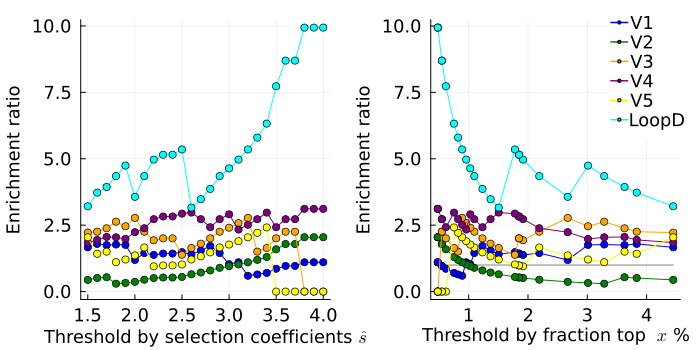

In [163]:
color_set = ["blue", "green", "orange", "purple", "yellow", "cyan"]
p1 = Plots.plot(100*s_threshold_RMs_set, x_fold_V1_set, label="V1", 
    xlabel=L"Threshold by selection coefficients $\hat{s}$", 
    ylabel="Enrichment ratio", 
    foreground_color_legend = nothing,
    c = color_set[1],
    labelfontsize=12,
    legendfontsize=12, 
    m=:circle,
    margin=3mm,
    legend=:false,
    tickfontsize=12,
)
Plots.plot!(100*s_threshold_RMs_set, x_fold_V2_set, label="V2", m=:circle, c = color_set[2])
Plots.plot!(100*s_threshold_RMs_set, x_fold_V3_set, label="V3", m=:circle, c = color_set[3],)
Plots.plot!(100*s_threshold_RMs_set, x_fold_V4_set, label="V4", m=:circle, c = color_set[4],)
Plots.plot!(100*s_threshold_RMs_set, x_fold_V5_set, label="V5", m=:circle, c = color_set[5],)
Plots.plot!(100*s_threshold_RMs_set, x_fold_LoopD_set, label="LoopD", m=:circle, c = color_set[6])

p2 = Plots.plot(100*α_selected_est, ones(size(α_selected_est)), label=:false, c=:gray)
Plots.plot!(100*α_selected_est, x_fold_V1_set, label="V1", 
    xlabel=L"Threshold by fraction top  $x$ %", 
    ylabel="Enrichment ratio", 
    c = color_set[1],
    foreground_color_legend = nothing,
    labelfontsize=12,
    legendfontsize=12, 
    m=:circle,
    tickfontsize=12,
    margin=3mm,
    legend=(0.8, 0.99)
)
Plots.plot!(100*α_selected_est, x_fold_V2_set, label="V2", m=:circle, c = color_set[2],)
Plots.plot!(100*α_selected_est, x_fold_V3_set, label="V3", m=:circle, c = color_set[3],)
Plots.plot!(100*α_selected_est, x_fold_V4_set, label="V4", m=:circle, c = color_set[4],)
Plots.plot!(100*α_selected_est, x_fold_V5_set, label="V5", m=:circle, c = color_set[5],)
Plots.plot!(100*α_selected_est, x_fold_LoopD_set, label="LoopD", m=:circle, c = color_set[6],)

Plots.plot(p1,p2, layout=(1,2), size=(700, 350))
#Plots.savefig("../fig/enrichment_vs_threshold_CH505.pdf")

In [168]:
count(csv_raw_CH505.s_MPL .> 0.030)

15

"/net/dali/home/barton/kais/submission/HIV_Coevolution/note"